# MIE1517 Group 11 - UofT Phishnet

### Authors
Abhay Singh Thakur (1011878096) <br>
Johnny Kim (1012475297) <br>
Darya Zanjanipour (1003605814)  <br>
Marc Bishara (996877447) <br>
Owais Hamid (1005719956)

### Introduction
This project aims to address the significant threat of phishing attacks targeting our university's email system. We will develop a robust machine learning model to automatically classify incoming emails as either legitimate or phishing.
Full project code and documentation can be found in this github repo: https://github.com/jk5279/Phishnet

### Datasets
For this project we will use 5 publicly available datasets suplimented with synthetic self generated emails. The datasets selected are:

1. [Arifa Islam, C. (2023)](https://zenodo.org/records/8339691): Includes 11 curated datasets from various sources. Split between Phishing and safe.
2. [Chakraborty, S. (2023)](https://www.kaggle.com/datasets/subhajournal/phishingemails): 18K Emails split between phishing / benign some of which came from Enron.
3. [Miltchev, R. (2025)](https://zenodo.org/records/13474746): 2K emails labelled phishing and safe from University of Twente
4. [Radev, D. (2008)](https://www.kaggle.com/datasets/llabhishekll/fraud-email-dataset) 11.5K Emails split 40 / 60 Phishing and safe.
5. [Anuran Roy (2023)](https://www.kaggle.com/datasets/anuranroy/hunter-biden-mails): Emails from Hunter Biden's laptop. Assumed to all be safe.

While we found a large corpus of email datasets, after studying them carefully we found that only a very small subset matched what we have personally experienced and identified as "modern sofisticated phshing emails targeted at students". As a result we decided to undertake an effort for data augmentation. To that end we used recent phishing emails that we received to our UofT emails as templates along with examples of Phishing emails published by UC Berkley's Information securtigy office that can be [found here](https://security.berkeley.edu/education-awareness/phishing/phishing-examples-archive). Based on those examples we generated 250 synthetic emails for training and testing our models.

All the datasets can be found in our GitHub repo using [this direct link](https://github.com/jk5279/Phishnet/tree/b787273f90a6102e75ffdd9918efd10f07743141/datasets/raw%20-%20DO%20NOT%20OVERWRITE).

This Google Colab notebook can be accessed at this link:
https://colab.research.google.com/drive/1tXWMzN2iarZQbXpIZONbiaALbHbz8QVH?usp=sharing

In [ ]:
!git lfs clone https://github.com/jk5279/Phishnet.git

          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'Phishnet'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 213 (delta 64), reused 186 (delta 44), pack-reused 0 (from 0)
Receiving objects: 100% (213/213), 6.28 MiB | 11.82 MiB/s, done.
Resolving deltas: 100% (64/64), done.


## Project Overview

This project implements phishing email detection using both traditional machine learning and deep learning approaches. The **Deep Learning (BERT) model** is our primary approach, achieving **89.54%% test accuracy** on a dataset of 1,127 samples.

This notebook provides a step-by-step guide showing our methodology, including data preparation, model architecture, training process, and evaluation results.


## 1. Data Preparation

The data preparation process combines multiple phishing email datasets, applies text cleaning, and creates train/validation/test splits. The final dataset contains **1,127 samples** with splits of 788 training samples (69.9%), 169 validation samples (15.0%), and 170 test samples (15.1%). The dataset is balanced with approximately 55% Safe (label=0) and 45% Phishing (label=1) emails.

In [ ]:
# Complete Data Preparation Code

import os
import sys
import glob
import re
import quopri
import multiprocessing
from typing import List, Dict, Optional
import warnings
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from bs4 import MarkupResemblesLocatorWarning
from tqdm.contrib.concurrent import process_map
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)

# Configuration
RAW_DATA_DIR = "/content/Phishnet/datasets/raw - DO NOT OVERWRITE"
TEST_DATASETS_DIR = "/content/Phishnet/datasets/raw - DO NOT OVERWRITE/test_datasets"
OUTPUT_DIR = "outputs"

COLUMN_CONFIG = {
    "text_columns": ["Email Text", "Text", "text", "body"],
    "label_columns": ["Email Type", "Class", "label"],
}

LABEL_MAP = {
    "Phishing Email": 1, "1.0": 1, "1": 1, "spam": 1,
    "Safe Email": 0, "0.0": 0, "0": 0, "ham": 0,
}

NUM_WORKERS = multiprocessing.cpu_count()
SAMPLE_SIZE = 1000

# Helper Functions
def set_max_csv_field_size_limit():
    """Set the CSV field size limit as high as possible."""
    import csv
    max_int = sys.maxsize
    while True:
        try:
            csv.field_size_limit(max_int)
            break
        except OverflowError:
            max_int = int(max_int / 10)

def is_git_lfs_pointer(df: pd.DataFrame) -> bool:
    """Check if DataFrame appears to be a Git LFS pointer file."""
    if df is None or df.empty:
        return False
    columns = list(df.columns)
    has_lfs_column = any('version https://git-lfs.github.com/spec/v1' in str(col) for col in columns)
    if has_lfs_column and len(df) > 0:
        first_val = str(df.iloc[0, 0]) if len(df) > 0 else ""
        has_oid = 'oid sha256:' in first_val
        return has_oid
    return has_lfs_column

def safe_read_csv(path: str) -> Optional[pd.DataFrame]:
    """Read a CSV using robust fallbacks for different encodings and formats."""
    try:
        df = pd.read_csv(path, engine="c")
        if is_git_lfs_pointer(df):
            return None
        return df
    except Exception:
        pass
    try:
        df = pd.read_csv(path, engine="c", encoding="latin1", on_bad_lines="skip")
        if is_git_lfs_pointer(df):
            return None
        return df
    except Exception:
        pass
    try:
        df = pd.read_csv(path, engine="python")
        if is_git_lfs_pointer(df):
            return None
        return df
    except Exception:
        return None

def consolidate_column(df: pd.DataFrame, possible_cols: List[str]) -> pd.Series:
    """Consolidate multiple possible column names into a single series."""
    result = None
    for col in possible_cols:
        if col in df.columns:
            if result is None:
                result = df[col].astype(str)
            else:
                result = result.fillna(df[col].astype(str))
    if result is None:
        raise ValueError(f"None of the expected columns found: {possible_cols}")
    return result.fillna("")

def clean_email_text(text: object) -> str:
    """Clean email text by removing HTML, normalizing URLs/emails."""
    if not isinstance(text, str):
        return ""
    # Decode quoted-printable
    try:
        text_bytes = text.encode("latin-1", errors="ignore")
        decoded_bytes = quopri.decodestring(text_bytes)
        text = decoded_bytes.decode("utf-8", errors="ignore")
    except Exception:
        pass
    # Strip HTML
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text(separator=" ")
    # Lowercase
    text = text.lower()
    # Replace URLs
    text = re.sub(r"(https?://\S+|www\.\S+)", "[url]", text)
    # Replace emails
    text = re.sub(r"\b[a-z0-9._%+-]+@[a-z0-9.-]+\.[a-z]{2,}\b", "[email]", text)
    # Keep alnum, space, and []
    text = re.sub(r"[^a-z0-9\s\[\]]", "", text)
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

def combine_dataset_files() -> pd.DataFrame:
    """Combine all CSV files from Dataset/raw, excluding test_datasets."""
    set_max_csv_field_size_limit()
    if not os.path.isdir(RAW_DATA_DIR):
        raise FileNotFoundError(f"Directory not found: {RAW_DATA_DIR}")
    pattern = os.path.join(RAW_DATA_DIR, "**", "*.csv")
    all_files = glob.glob(pattern, recursive=True)
    files = [f for f in all_files if TEST_DATASETS_DIR not in f]
    if not files:
        raise FileNotFoundError(f"No CSV files found in: {RAW_DATA_DIR}")
    dfs: List[pd.DataFrame] = []
    git_lfs_count = 0
    for f in files:
        df = safe_read_csv(f)
        if df is not None and not df.empty:
            if is_git_lfs_pointer(df):
                git_lfs_count += 1
                continue
            df["source_file"] = os.path.basename(f)
            relative_dir = os.path.relpath(os.path.dirname(f), RAW_DATA_DIR)
            if relative_dir == ".":
                df["source_name"] = os.path.basename(os.path.normpath(RAW_DATA_DIR))
            else:
                df["source_name"] = relative_dir.split(os.sep)[0]
            dfs.append(df)
    if not dfs:
        error_msg = f"\n{'='*60}\nERROR: No valid CSV data files could be read.\n"
        if git_lfs_count > 0:
            error_msg += f"Found {git_lfs_count} Git LFS pointer files.\n\n"
            error_msg += "SOLUTION: Download the actual data files using Git LFS:\n"
            error_msg += "  1. Make sure Git LFS is installed: git lfs install\n"
            error_msg += "  2. Pull the actual files: git lfs pull\n"
            error_msg += "  3. Run this script again\n"
        error_msg += "="*60 + "\n"
        raise RuntimeError(error_msg)
    combined = pd.concat(dfs, ignore_index=True)
    return combined

def process_to_master_format(df: pd.DataFrame) -> pd.DataFrame:
    """Consolidate text/label columns and standardize labels."""
    master_text = consolidate_column(df, COLUMN_CONFIG["text_columns"])
    master_label_src = consolidate_column(df, COLUMN_CONFIG["label_columns"])
    normalized_map = {str(k).lower().strip(): v for k, v in LABEL_MAP.items()}
    normalized_labels = master_label_src.astype(str).str.lower().str.strip()
    master_label = normalized_labels.map(normalized_map)
    final_df = pd.DataFrame({"text": master_text, "label": master_label})
    final_df = final_df.dropna(subset=["text", "label"])
    if len(final_df) == 0:
        raise RuntimeError("Master dataset empty after cleaning.")
    final_df["label"] = final_df["label"].astype(int)
    return final_df

def clean_dataset_text(df: pd.DataFrame) -> pd.DataFrame:
    """Apply text cleaning to the dataset."""
    df = df.copy()
    df["text"] = df["text"].fillna("")
    results = process_map(
        clean_email_text, df["text"],
        max_workers=NUM_WORKERS, chunksize=500, desc="Cleaning Emails"
    )
    df["text"] = results
    df = df[df["text"].str.strip().str.len() > 0]
    return df

def sample_dataset(df: pd.DataFrame, n_samples: int = SAMPLE_SIZE) -> pd.DataFrame:
    """Sample n_samples from dataset, stratified by label if possible."""
    if len(df) <= n_samples:
        return df
    try:
        sampled, _ = train_test_split(
            df, train_size=n_samples, stratify=df["label"], random_state=42
        )
        return sampled.reset_index(drop=True)
    except ValueError:
        return df.sample(n=n_samples, random_state=42).reset_index(drop=True)

def load_test_datasets() -> pd.DataFrame:
    """Load all CSV files from test_datasets directory and process them."""
    if not os.path.isdir(TEST_DATASETS_DIR):
        print(f"Warning: Test datasets directory not found: {TEST_DATASETS_DIR}")
        return pd.DataFrame(columns=["text", "label"])

    test_dfs = []
    pattern = os.path.join(TEST_DATASETS_DIR, "*.csv")
    files = glob.glob(pattern)

    if not files:
        print(f"Warning: No CSV files found in test datasets directory: {TEST_DATASETS_DIR}")
        return pd.DataFrame(columns=["text", "label"])

    git_lfs_count = 0
    for f in files:
        df = safe_read_csv(f)
        if df is not None and not df.empty:
            if is_git_lfs_pointer(df):
                git_lfs_count += 1
                print(f"Warning: Skipping Git LFS pointer file: {os.path.basename(f)}")
                continue

            # Attempt to consolidate columns based on COLUMN_CONFIG
            try:
                processed_df = process_to_master_format(df)
                test_dfs.append(processed_df)
            except ValueError as e:
                print(f"Warning: Could not process file {os.path.basename(f)}: {e}")
                print("         Skipping this file.")
                continue
        elif df is None:
             print(f"Warning: Could not read file: {os.path.basename(f)}")
        elif df.empty:
             print(f"Warning: Skipping empty file: {os.path.basename(f)}")


    if not test_dfs:
        error_msg = f"\n{'='*60}\nERROR: No valid test CSV data files could be read.\n"
        if git_lfs_count > 0:
            error_msg += f"Found {git_lfs_count} Git LFS pointer files. Use 'git lfs pull' to download.\n"
        error_msg += "="*60 + "\n"
        print(error_msg) # Print error instead of raising to allow pipeline to continue
        return pd.DataFrame(columns=["text", "label"])


    combined_test = pd.concat(test_dfs, ignore_index=True)
    combined_test["text"] = combined_test["text"].fillna("")

    # Clean text for all test datasets
    results = process_map(
        clean_email_text, combined_test["text"],
        max_workers=NUM_WORKERS, chunksize=500, desc="Cleaning Test Emails"
    )
    combined_test["text"] = results
    combined_test = combined_test[combined_test["text"].str.strip().str.len() > 0]

    # Ensure labels are integers
    combined_test['label'] = combined_test['label'].astype(int)

    return combined_test

def create_train_val_test_splits(sampled_df: pd.DataFrame, test_datasets_df: pd.DataFrame) -> tuple:
    """Combine datasets and create train/val/test splits."""
    combined_df = pd.concat([sampled_df, test_datasets_df], ignore_index=True)
    train_df, temp_df = train_test_split(
        combined_df, test_size=0.3, stratify=combined_df["label"], random_state=42
    )
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
    )
    return train_df, val_df, test_df, combined_df

print("✓ All data preparation functions loaded (complete implementation from 00_data_preparation.py)")
print("\nMain pipeline steps:")
print("1. Combine CSV files from Dataset/raw (excluding test_datasets)")
print("2. Consolidate text/label columns and standardize labels (0=Safe, 1=Phishing)")
print("3. Apply text cleaning (clean_email_text function)")
print("4. Sample approximately 1000 samples (stratified by label)")
print("5. Load test_datasets (all CSV files in the test_datasets directory)")
print("6. Create train/validation/test splits (70/15/15)")
print("\nOutputs: report/outputs/train.csv, val.csv, test.csv, combined_dataset_final.csv")

# Execute data preparation if outputs don't exist
print("\n" + "=" * 60)
print("Checking if data preparation outputs exist...")
print("=" * 60)

os.makedirs(OUTPUT_DIR, exist_ok=True)
train_output = os.path.join(OUTPUT_DIR, "train.csv")
val_output = os.path.join(OUTPUT_DIR, "val.csv")
test_output = os.path.join(OUTPUT_DIR, "test.csv")
combined_output = os.path.join(OUTPUT_DIR, "combined_dataset_final.csv")

if not (os.path.exists(train_output) and os.path.exists(val_output) and os.path.exists(test_output)):
    print("\nData preparation outputs not found. Running data preparation pipeline...")
    print("This may take a few minutes...")

    # Step 1: Combine dataset files
    print("\n[1/6] Combining CSV files from Dataset/raw...")
    combined_raw = combine_dataset_files()
    print(f"  ✓ Combined {len(combined_raw):,} raw samples")

    # Step 2: Process to master format
    print("\n[2/6] Processing to master format...")
    master_df = process_to_master_format(combined_raw)
    print(f"  ✓ Master format: {len(master_df):,} samples")

    # Step 3: Clean text
    print("\n[3/6] Cleaning email text...")
    cleaned_df = clean_dataset_text(master_df)
    print(f"  ✓ Cleaned: {len(cleaned_df):,} samples")

    # Step 4: Sample dataset
    print(f"\n[4/6] Sampling {SAMPLE_SIZE} samples...")
    sampled_df = sample_dataset(cleaned_df, n_samples=SAMPLE_SIZE)
    print(f"  ✓ Sampled: {len(sampled_df):,} samples")

    # Step 5: Load test datasets
    print("\n[5/6] Loading test datasets...")
    test_datasets_df = load_test_datasets()
    print(f"  ✓ Test datasets: {len(test_datasets_df):,} samples")

    # Step 6: Create splits
    print("\n[6/6] Creating train/validation/test splits...")
    train_df, val_df, test_df, combined_df = create_train_val_test_splits(sampled_df, test_datasets_df)
    print(f"  ✓ Train: {len(train_df):,} samples")
    print(f"  ✓ Validation: {len(val_df):,} samples")
    print(f"  ✓ Test: {len(test_df):,} samples")

    # Save outputs
    print("\nSaving outputs...")
    train_df.to_csv(train_output, index=False)
    val_df.to_csv(val_output, index=False)
    test_df.to_csv(test_output, index=False)
    combined_df.to_csv(combined_output, index=False)
    print(f"  ✓ Saved to {OUTPUT_DIR}/")

    print("\n" + "=" * 60)
    print("✓ Data preparation complete!")
    print("=" * 60)
else:
    print("\n✓ Data preparation outputs already exist.")
    print("  Skipping data preparation (using existing outputs)")

✓ All data preparation functions loaded (complete implementation from 00_data_preparation.py)

Main pipeline steps:
1. Combine CSV files from Dataset/raw (excluding test_datasets)
2. Consolidate text/label columns and standardize labels (0=Safe, 1=Phishing)
3. Apply text cleaning (clean_email_text function)
4. Sample approximately 1000 samples (stratified by label)
5. Load test_datasets (all CSV files in the test_datasets directory)
6. Create train/validation/test splits (70/15/15)

Outputs: report/outputs/train.csv, val.csv, test.csv, combined_dataset_final.csv

Checking if data preparation outputs exist...

✓ Data preparation outputs already exist.
  Skipping data preparation (using existing outputs)


In [ ]:
import pandas as pd
import numpy as np
import json
import warnings
from pathlib import Path
from IPython.display import Image, display
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# Set paths
base_dir = Path('..')
models_dir = base_dir / 'models'
outputs_dir = Path('outputs')

# Load datasets from 00_data_preparation.py outputs
train_path = outputs_dir / 'train.csv'
val_path = outputs_dir / 'val.csv'
test_path = outputs_dir / 'test.csv'
combined_path = outputs_dir / 'combined_dataset_final.csv'

print("Dataset Statistics (from 00_data_preparation.py):")
print("=" * 60)

if combined_path.exists():
    combined_df = pd.read_csv(combined_path)
    print(f"\nCombined Dataset: {len(combined_df):,} samples")
    print(f"Label distribution:")
    label_counts = combined_df['label'].value_counts().sort_index()
    for label, count in label_counts.items():
        label_name = "Phishing" if label == 1 else "Safe"
        print(f"  {label_name} (label={label}): {count:,} ({count/len(combined_df)*100:.1f}%)")

# Load datasets (will be created by data preparation cell if they don't exist)
if train_path.exists() and val_path.exists() and test_path.exists():
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)

    print(f"\nTrain/Validation/Test Splits:")
    print(f"  Train: {len(train_df):,} samples ({len(train_df)/(len(train_df)+len(val_df)+len(test_df))*100:.1f}%)")
    print(f"  Validation: {len(val_df):,} samples ({len(val_df)/(len(train_df)+len(val_df)+len(test_df))*100:.1f}%)")
    print(f"  Test: {len(test_df):,} samples ({len(test_df)/(len(train_df)+len(val_df)+len(test_df))*100:.1f}%)")
else:
    print("\nTrain/val/test splits not found.")
    print("Please run the data preparation cell (Cell 2) first to generate the datasets.")
    print("The data preparation cell will automatically run if outputs don't exist.")


Dataset Statistics (from 00_data_preparation.py):

Combined Dataset: 1,000 samples
Label distribution:
  Safe (label=0): 597 (59.7%)
  Phishing (label=1): 403 (40.3%)

Train/Validation/Test Splits:
  Train: 700 samples (70.0%)
  Validation: 150 samples (15.0%)
  Test: 150 samples (15.0%)


## 2. Exploratory Data Analysis (DL-Style)

This section performs comprehensive exploratory data analysis on the train, validation, and test splits generated from `00_data_preparation.py`. The EDA uses DL-style preprocessing (preserving case and punctuation) and includes visualizations for label distributions, metadata features, n-grams, and word clouds.


In [ ]:
# Complete EDA Functions (DL-Style)
# All functions from 03_dl_preprocessing_eda.py, modified for inline display

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import string
from IPython.display import display, Image
import os

# Set seaborn style for consistent plots
sns.set(style="whitegrid", context="notebook")

# Setup NLTK
def setup_nltk():
    """Download NLTK stopwords if not already available."""
    try:
        nltk.download('stopwords', quiet=True)
        return set(stopwords.words('english'))
    except Exception as e:
        print(f"Warning: Could not download NLTK stopwords: {e}")
        return set()

# Engineer metadata features
def engineer_metadata_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Engineer metadata features from text.

    NOTE: These features are ONLY for EDA visualization purposes.
    They are NOT used in the DL training pipeline, which relies
    solely on learned features from BERT embeddings.
    """
    df = df.copy()
    df['text_length'] = df['text'].apply(lambda x: len(str(x)))
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    df['punct_count'] = df['text'].apply(
        lambda x: sum([1 for char in str(x) if char in string.punctuation])
    )
    df['upper_count'] = df['text'].apply(
        lambda x: len([word for word in str(x).split() if word.isupper()])
    )
    return df

# Plotting functions (modified for inline display)
def plot_target_distribution(df: pd.DataFrame, output_dir: str, split_name: str = ""):
    """Plot target label distribution."""
    print(f"\n--- EDA: Target Distribution ({split_name}) ---")
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x='label')
    title = f'Distribution of Labels (0=Not Phishing, 1=Phishing) - {split_name}'
    plt.title(title)
    plt.tight_layout()

    # Save file
    filename = f"{split_name}_dl_target_label_distribution.png" if split_name else "dl_target_label_distribution.png"
    filepath = os.path.join(output_dir, filename)
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(filepath, dpi=150, bbox_inches='tight')

    # Display inline
    plt.show()
    print(f" - Saved: {filename}")

def plot_metadata_distributions(df: pd.DataFrame, output_dir: str, split_name: str = ""):
    """Plot distributions of metadata features."""
    print(f"\n--- EDA: Metadata Feature Distributions ({split_name}) ---")
    df['label_name'] = df['label'].map({0: 'Not Phishing (0)', 1: 'Phishing (1)'})

    meta_features = ['text_length', 'word_count', 'punct_count', 'upper_count']
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()

    for i, feature in enumerate(meta_features):
        sns.histplot(
            data=df, x=feature, hue='label_name', kde=False,
            ax=axes[i], bins=50, element="step"
        )
        q99 = df[feature].quantile(0.99)
        if q99 > 0:
            axes[i].set_xlim(0, q99)
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature.replace('_', ' ').title())

    plt.tight_layout()

    # Save file
    filename = f"{split_name}_dl_metadata_histograms.png" if split_name else "dl_metadata_histograms.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=150, bbox_inches='tight')

    # Display inline
    plt.show()
    print(f" - Saved: {filename}")

def plot_correlation_heatmap(df: pd.DataFrame, output_dir: str, split_name: str = ""):
    """Plot correlation heatmap of engineered features."""
    print(f"\n--- EDA: Correlation Heatmap ({split_name}) ---")
    numeric_features = ['label', 'text_length', 'word_count', 'punct_count', 'upper_count']
    corr_matrix = df[numeric_features].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="vlag", center=0)
    title = f'Correlation of Engineered Features and Label - {split_name}'
    plt.title(title)
    plt.tight_layout()

    # Save file
    filename = f"{split_name}_dl_engineered_features_heatmap.png" if split_name else "dl_engineered_features_heatmap.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=150, bbox_inches='tight')

    # Display inline
    plt.show()
    print(f" - Saved: {filename}")

def plot_source_file_analysis(df: pd.DataFrame, output_dir: str, split_name: str = ""):
    """Plot label distribution by source file."""
    print(f"\n--- EDA: Source File Analysis ({split_name}) ---")
    if 'source_file' not in df.columns:
        print(" - Skipping: source_file column not found")
        return

    top_sources = df['source_file'].value_counts().head(10).index
    df_top_sources = df[df['source_file'].isin(top_sources)]

    plt.figure(figsize=(10, 8))
    sns.countplot(data=df_top_sources, y='source_file', hue='label', order=top_sources)
    title = f'Label Distribution by Top 10 Source Files - {split_name}'
    plt.title(title)
    plt.tight_layout()

    # Save file
    filename = f"{split_name}_dl_source_file_by_label.png" if split_name else "dl_source_file_by_label.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=150, bbox_inches='tight')

    # Display inline
    plt.show()
    print(f" - Saved: {filename}")

def get_top_ngrams(corpus, n_gram_range=(1, 1), top_k=20):
    """Get top n-grams from corpus."""
    vec = CountVectorizer(ngram_range=n_gram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

def plot_top_ngrams(ngram_list, title, ax):
    """Plot top n-grams."""
    ngrams = [item[0] for item in ngram_list]
    frequencies = [item[1] for item in ngram_list]
    sns.barplot(x=frequencies, y=ngrams, ax=ax, palette='viridis')
    ax.set_title(title)

def plot_ngram_analysis(df: pd.DataFrame, output_dir: str, split_name: str = ""):
    """Plot n-gram analysis for phishing vs non-phishing."""
    print(f"\n--- EDA: N-Gram Analysis ({split_name}) ---")
    spam_corpus = df[df['label'] == 1]['text'].astype(str)
    ham_corpus = df[df['label'] == 0]['text'].astype(str)

    # Get top n-grams
    top_spam_unigrams = get_top_ngrams(spam_corpus, n_gram_range=(1, 1), top_k=20)
    top_ham_unigrams = get_top_ngrams(ham_corpus, n_gram_range=(1, 1), top_k=20)
    top_spam_bigrams = get_top_ngrams(spam_corpus, n_gram_range=(2, 2), top_k=20)
    top_ham_bigrams = get_top_ngrams(ham_corpus, n_gram_range=(2, 2), top_k=20)

    # Plot n-grams
    fig, axes = plt.subplots(2, 2, figsize=(20, 18))
    plot_top_ngrams(top_spam_unigrams, 'Top 20 Phishing Unigrams (Label 1)', axes[0, 0])
    plot_top_ngrams(top_ham_unigrams, 'Top 20 Not Phishing Unigrams (Label 0)', axes[0, 1])
    plot_top_ngrams(top_spam_bigrams, 'Top 20 Phishing Bigrams (Label 1)', axes[1, 0])
    plot_top_ngrams(top_ham_bigrams, 'Top 20 Not Phishing Bigrams (Label 0)', axes[1, 1])

    plt.tight_layout()

    # Save file
    filename = f"{split_name}_dl_ngram_analysis.png" if split_name else "dl_ngram_analysis.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=150, bbox_inches='tight')

    # Display inline
    plt.show()
    print(f" - Saved: {filename}")

def plot_word_clouds(df: pd.DataFrame, output_dir: str, stop_words_set: set, split_name: str = ""):
    """Generate word clouds for phishing vs non-phishing."""
    print(f"\n--- EDA: Word Clouds ({split_name}) ---")
    spam_corpus = df[df['label'] == 1]['text'].astype(str)
    ham_corpus = df[df['label'] == 0]['text'].astype(str)

    spam_text = " ".join(text for text in spam_corpus)
    ham_text = " ".join(text for text in ham_corpus)

    if spam_text and ham_text:
        try:
            wordcloud_spam = WordCloud(
                stopwords=stop_words_set, background_color="white",
                max_words=100, width=800, height=400
            ).generate(spam_text)
            wordcloud_ham = WordCloud(
                stopwords=stop_words_set, background_color="white",
                max_words=100, width=800, height=400
            ).generate(ham_text)

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
            ax1.imshow(wordcloud_spam, interpolation='bilinear')
            ax1.set_title('Phishing (Label 1)', fontsize=20)
            ax1.axis("off")

            ax2.imshow(wordcloud_ham, interpolation='bilinear')
            ax2.set_title('Not Phishing (Label 0)', fontsize=20)
            ax2.axis("off")

            plt.tight_layout()

            # Save file
            filename = f"{split_name}_dl_word_clouds.png" if split_name else "dl_word_clouds.png"
            filepath = os.path.join(output_dir, filename)
            plt.savefig(filepath, dpi=150, bbox_inches='tight')

            # Display inline
            plt.show()
            print(f" - Saved: {filename}")
        except Exception as e:
            print(f" - Skipping word clouds due to error: {e}")
    else:
        print(" - Skipping word clouds (empty corpus)")

def run_eda(df: pd.DataFrame, output_dir: str, split_name: str = ""):
    """Run all EDA visualizations for a dataset split."""
    print("\n" + "=" * 60)
    print(f"Starting Exploratory Data Analysis - {split_name}")
    print("=" * 60)

    # Setup
    os.makedirs(output_dir, exist_ok=True)
    stop_words_set = setup_nltk()

    print(f"\nDataset shape: {df.shape}")

    # Run EDA steps
    plot_target_distribution(df, output_dir, split_name)
    df = engineer_metadata_features(df)
    plot_metadata_distributions(df, output_dir, split_name)
    plot_correlation_heatmap(df, output_dir, split_name)
    plot_source_file_analysis(df, output_dir, split_name)
    plot_ngram_analysis(df, output_dir, split_name)
    plot_word_clouds(df, output_dir, stop_words_set, split_name)

    print("\n" + "=" * 60)
    print(f"EDA Complete for {split_name}!")
    print(f"All outputs saved to: {output_dir}")
    print("=" * 60)

    return df

print("✓ All EDA functions loaded (complete implementation from 03_dl_preprocessing_eda.py)")
print("Functions modified to display inline while saving to files")

✓ All EDA functions loaded (complete implementation from 03_dl_preprocessing_eda.py)
Functions modified to display inline while saving to files


### 2.1 EDA on Training Set

Running EDA on Training Set (788 samples)...

Starting Exploratory Data Analysis - train

Dataset shape: (788, 2)

--- EDA: Target Distribution (train) ---


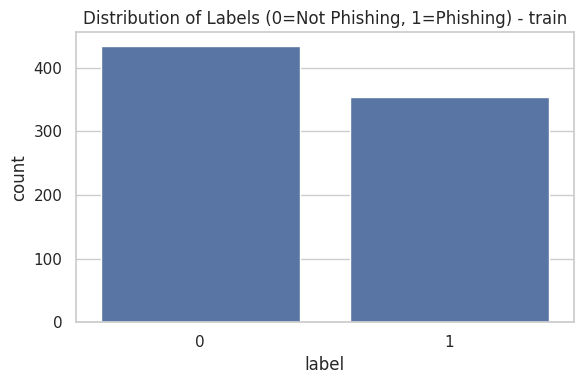

 - Saved: train_dl_target_label_distribution.png

--- EDA: Metadata Feature Distributions (train) ---


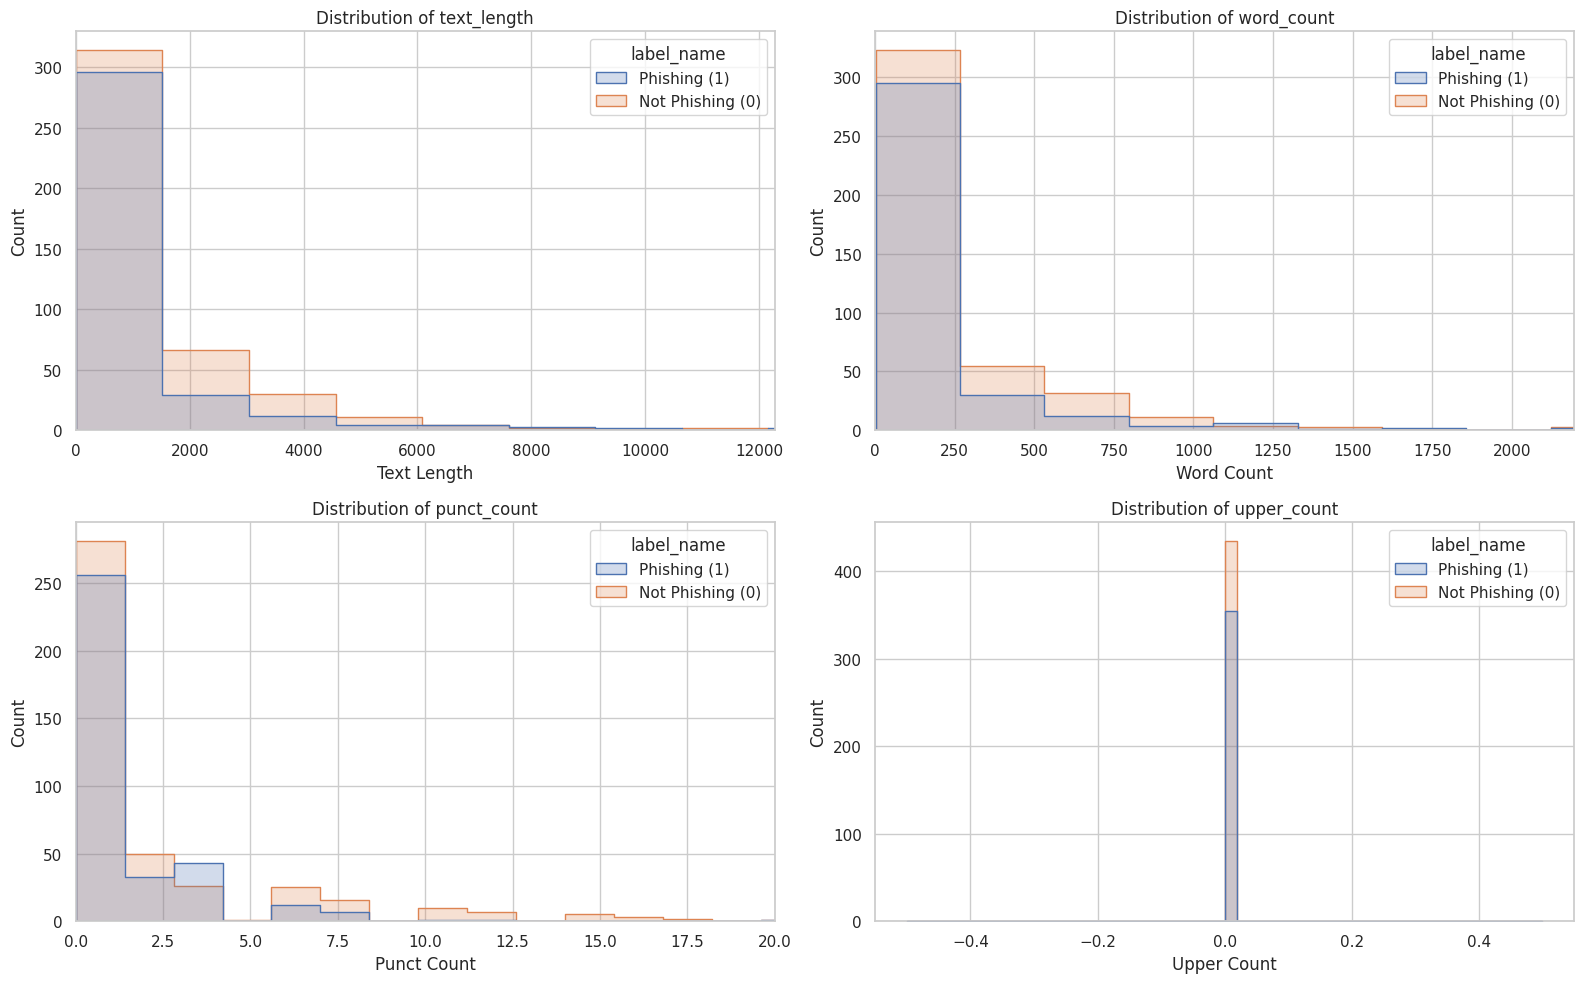

 - Saved: train_dl_metadata_histograms.png

--- EDA: Correlation Heatmap (train) ---


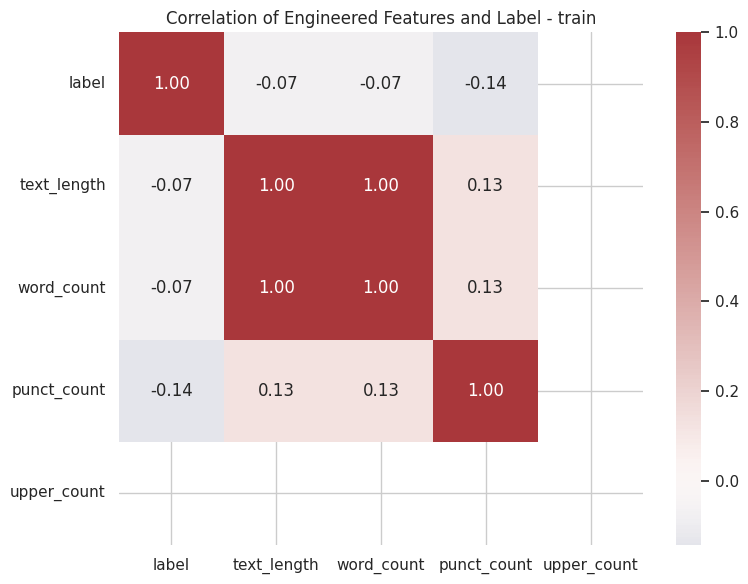

 - Saved: train_dl_engineered_features_heatmap.png

--- EDA: Source File Analysis (train) ---
 - Skipping: source_file column not found

--- EDA: N-Gram Analysis (train) ---


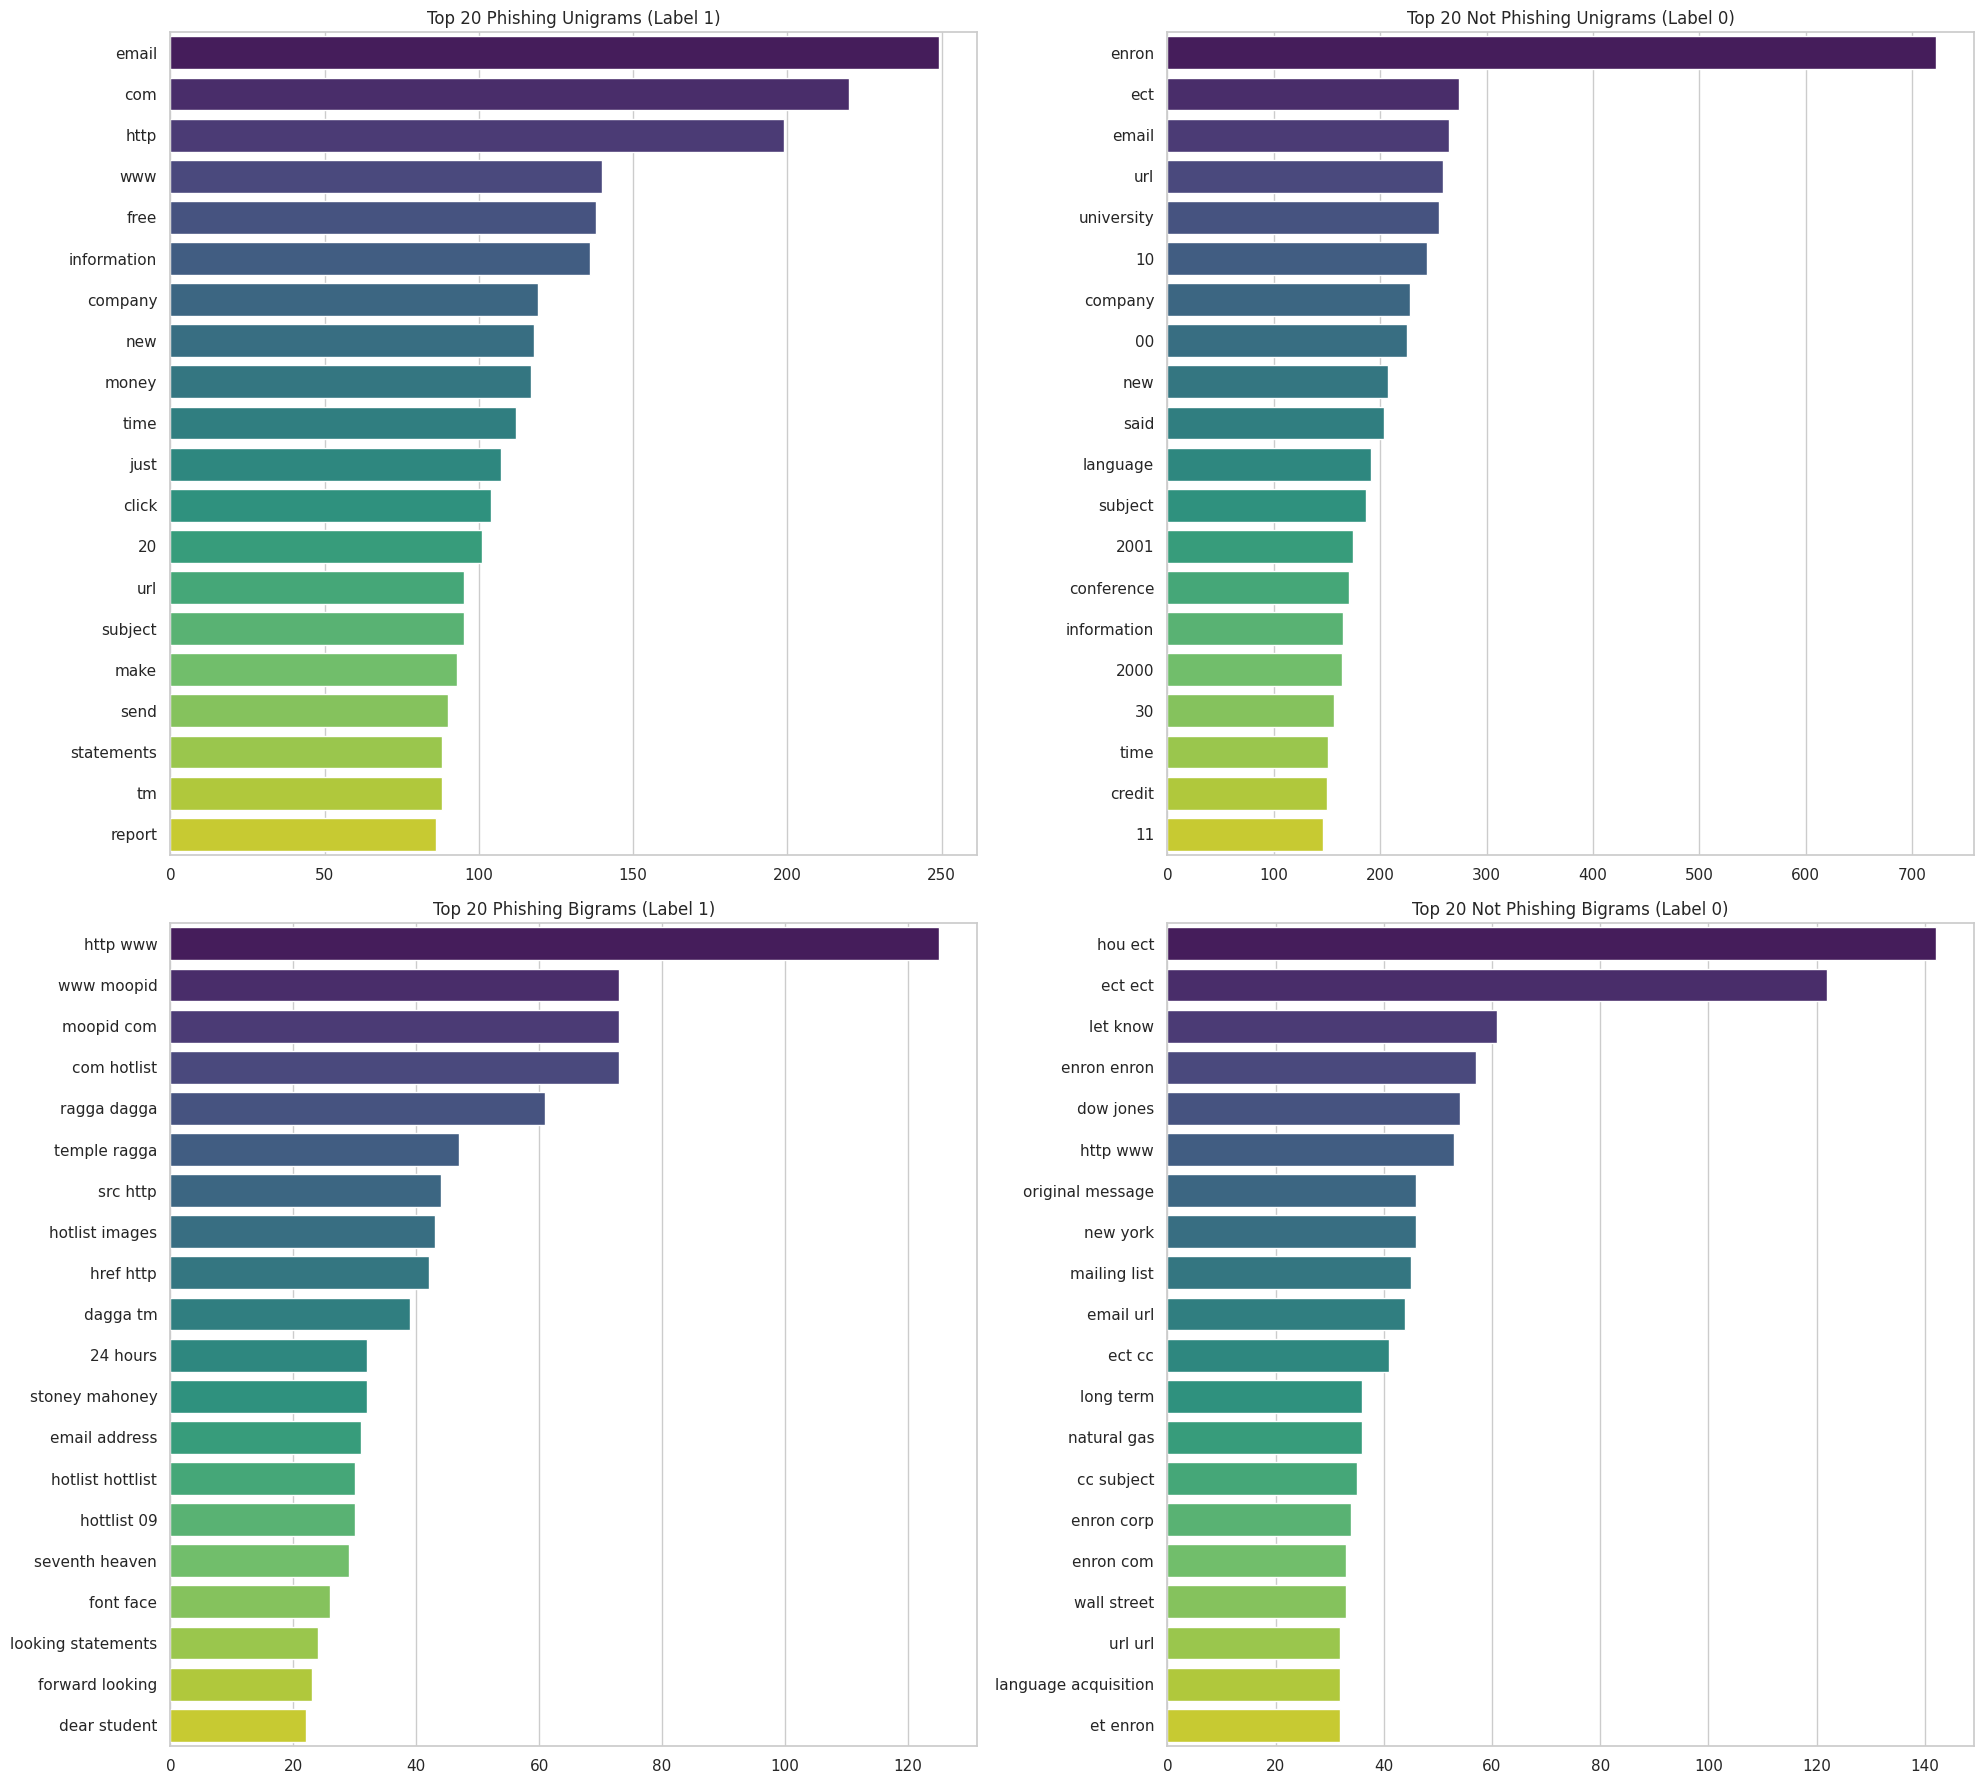

 - Saved: train_dl_ngram_analysis.png

--- EDA: Word Clouds (train) ---


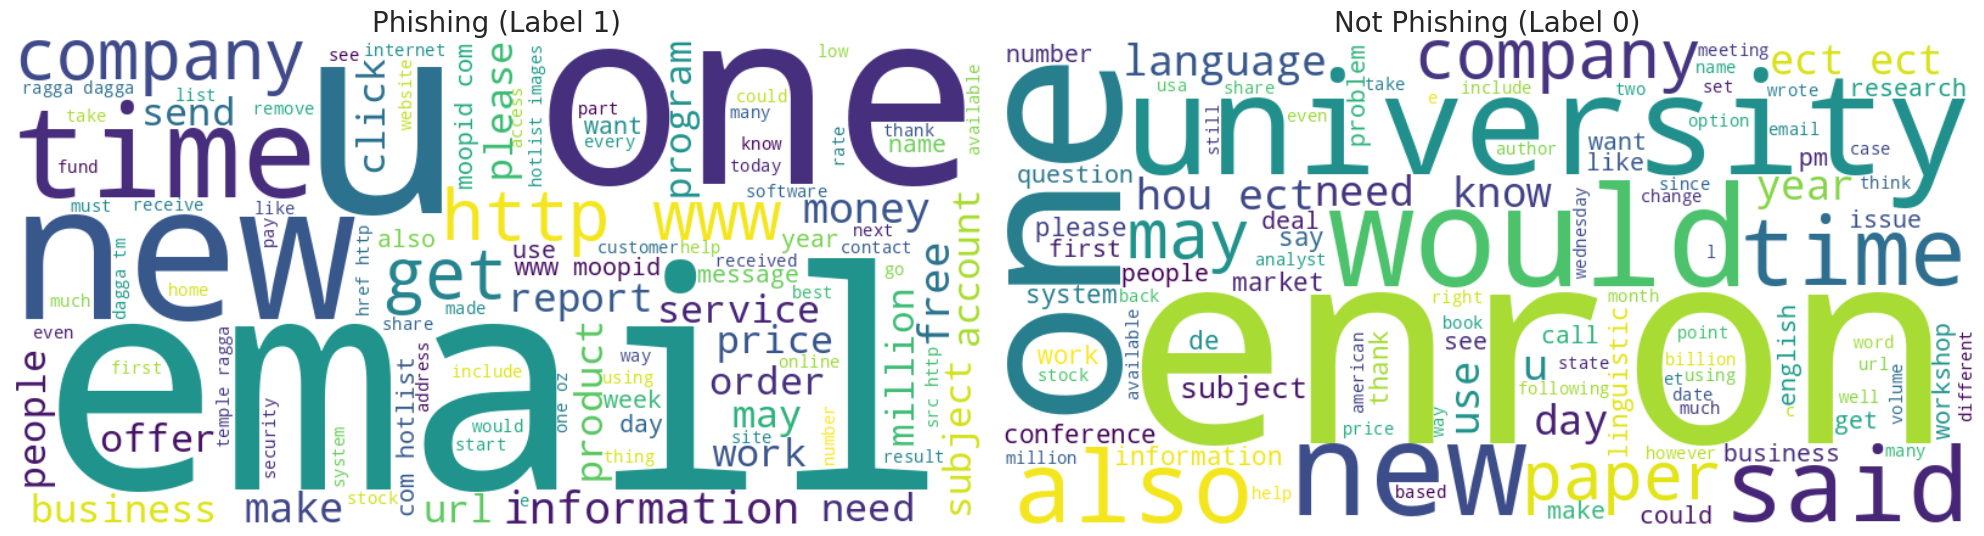

 - Saved: train_dl_word_clouds.png

EDA Complete for train!
All outputs saved to: ../eda_outputs


In [ ]:
# Run EDA on Training Set
eda_output_dir = '../eda_outputs'

if train_path.exists():
    train_df = pd.read_csv(train_path)
    print(f"Running EDA on Training Set ({len(train_df):,} samples)...")
    train_df = run_eda(train_df, eda_output_dir, split_name='train')
else:
    print(f"Training set not found at {train_path}")
    print("Please run the data preparation cell (Cell 2) first to generate the datasets.")
    print("The data preparation cell will automatically run if outputs don't exist.")


### 2.2 EDA on Validation Set

Running EDA on Validation Set (169 samples)...

Starting Exploratory Data Analysis - val

Dataset shape: (169, 2)

--- EDA: Target Distribution (val) ---


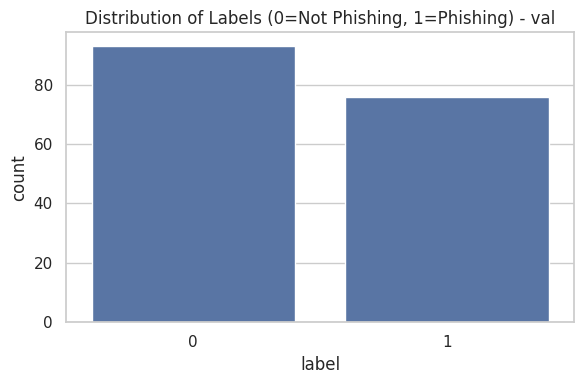

 - Saved: val_dl_target_label_distribution.png

--- EDA: Metadata Feature Distributions (val) ---


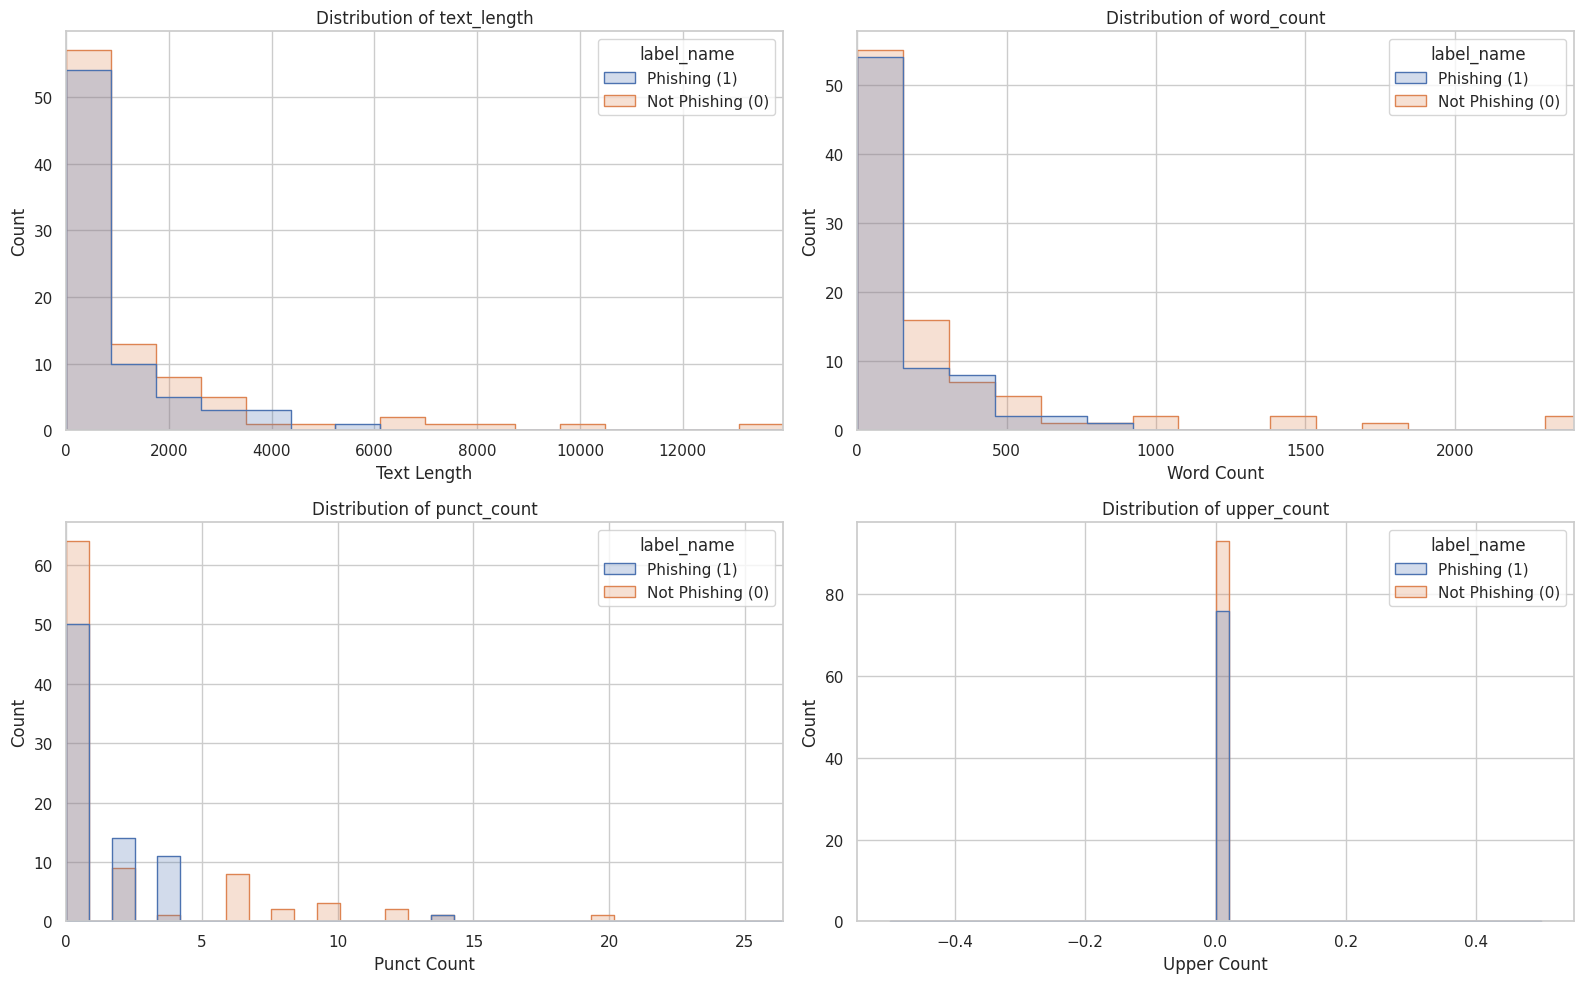

 - Saved: val_dl_metadata_histograms.png

--- EDA: Correlation Heatmap (val) ---


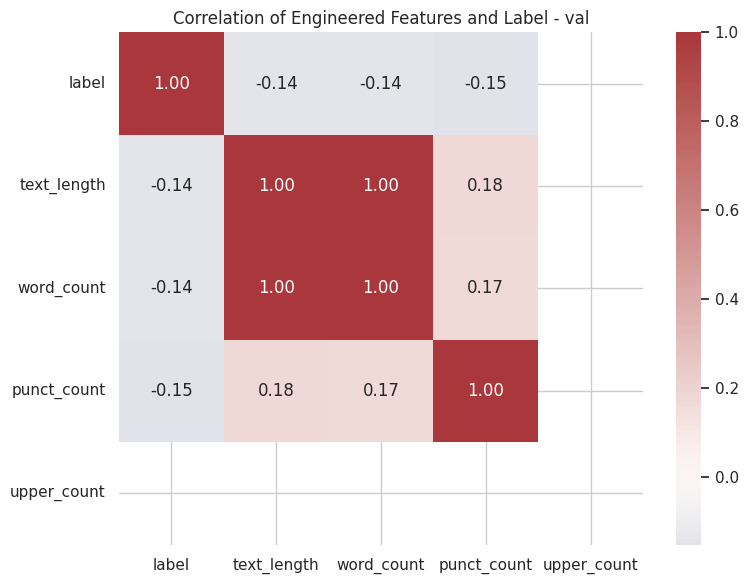

 - Saved: val_dl_engineered_features_heatmap.png

--- EDA: Source File Analysis (val) ---
 - Skipping: source_file column not found

--- EDA: N-Gram Analysis (val) ---


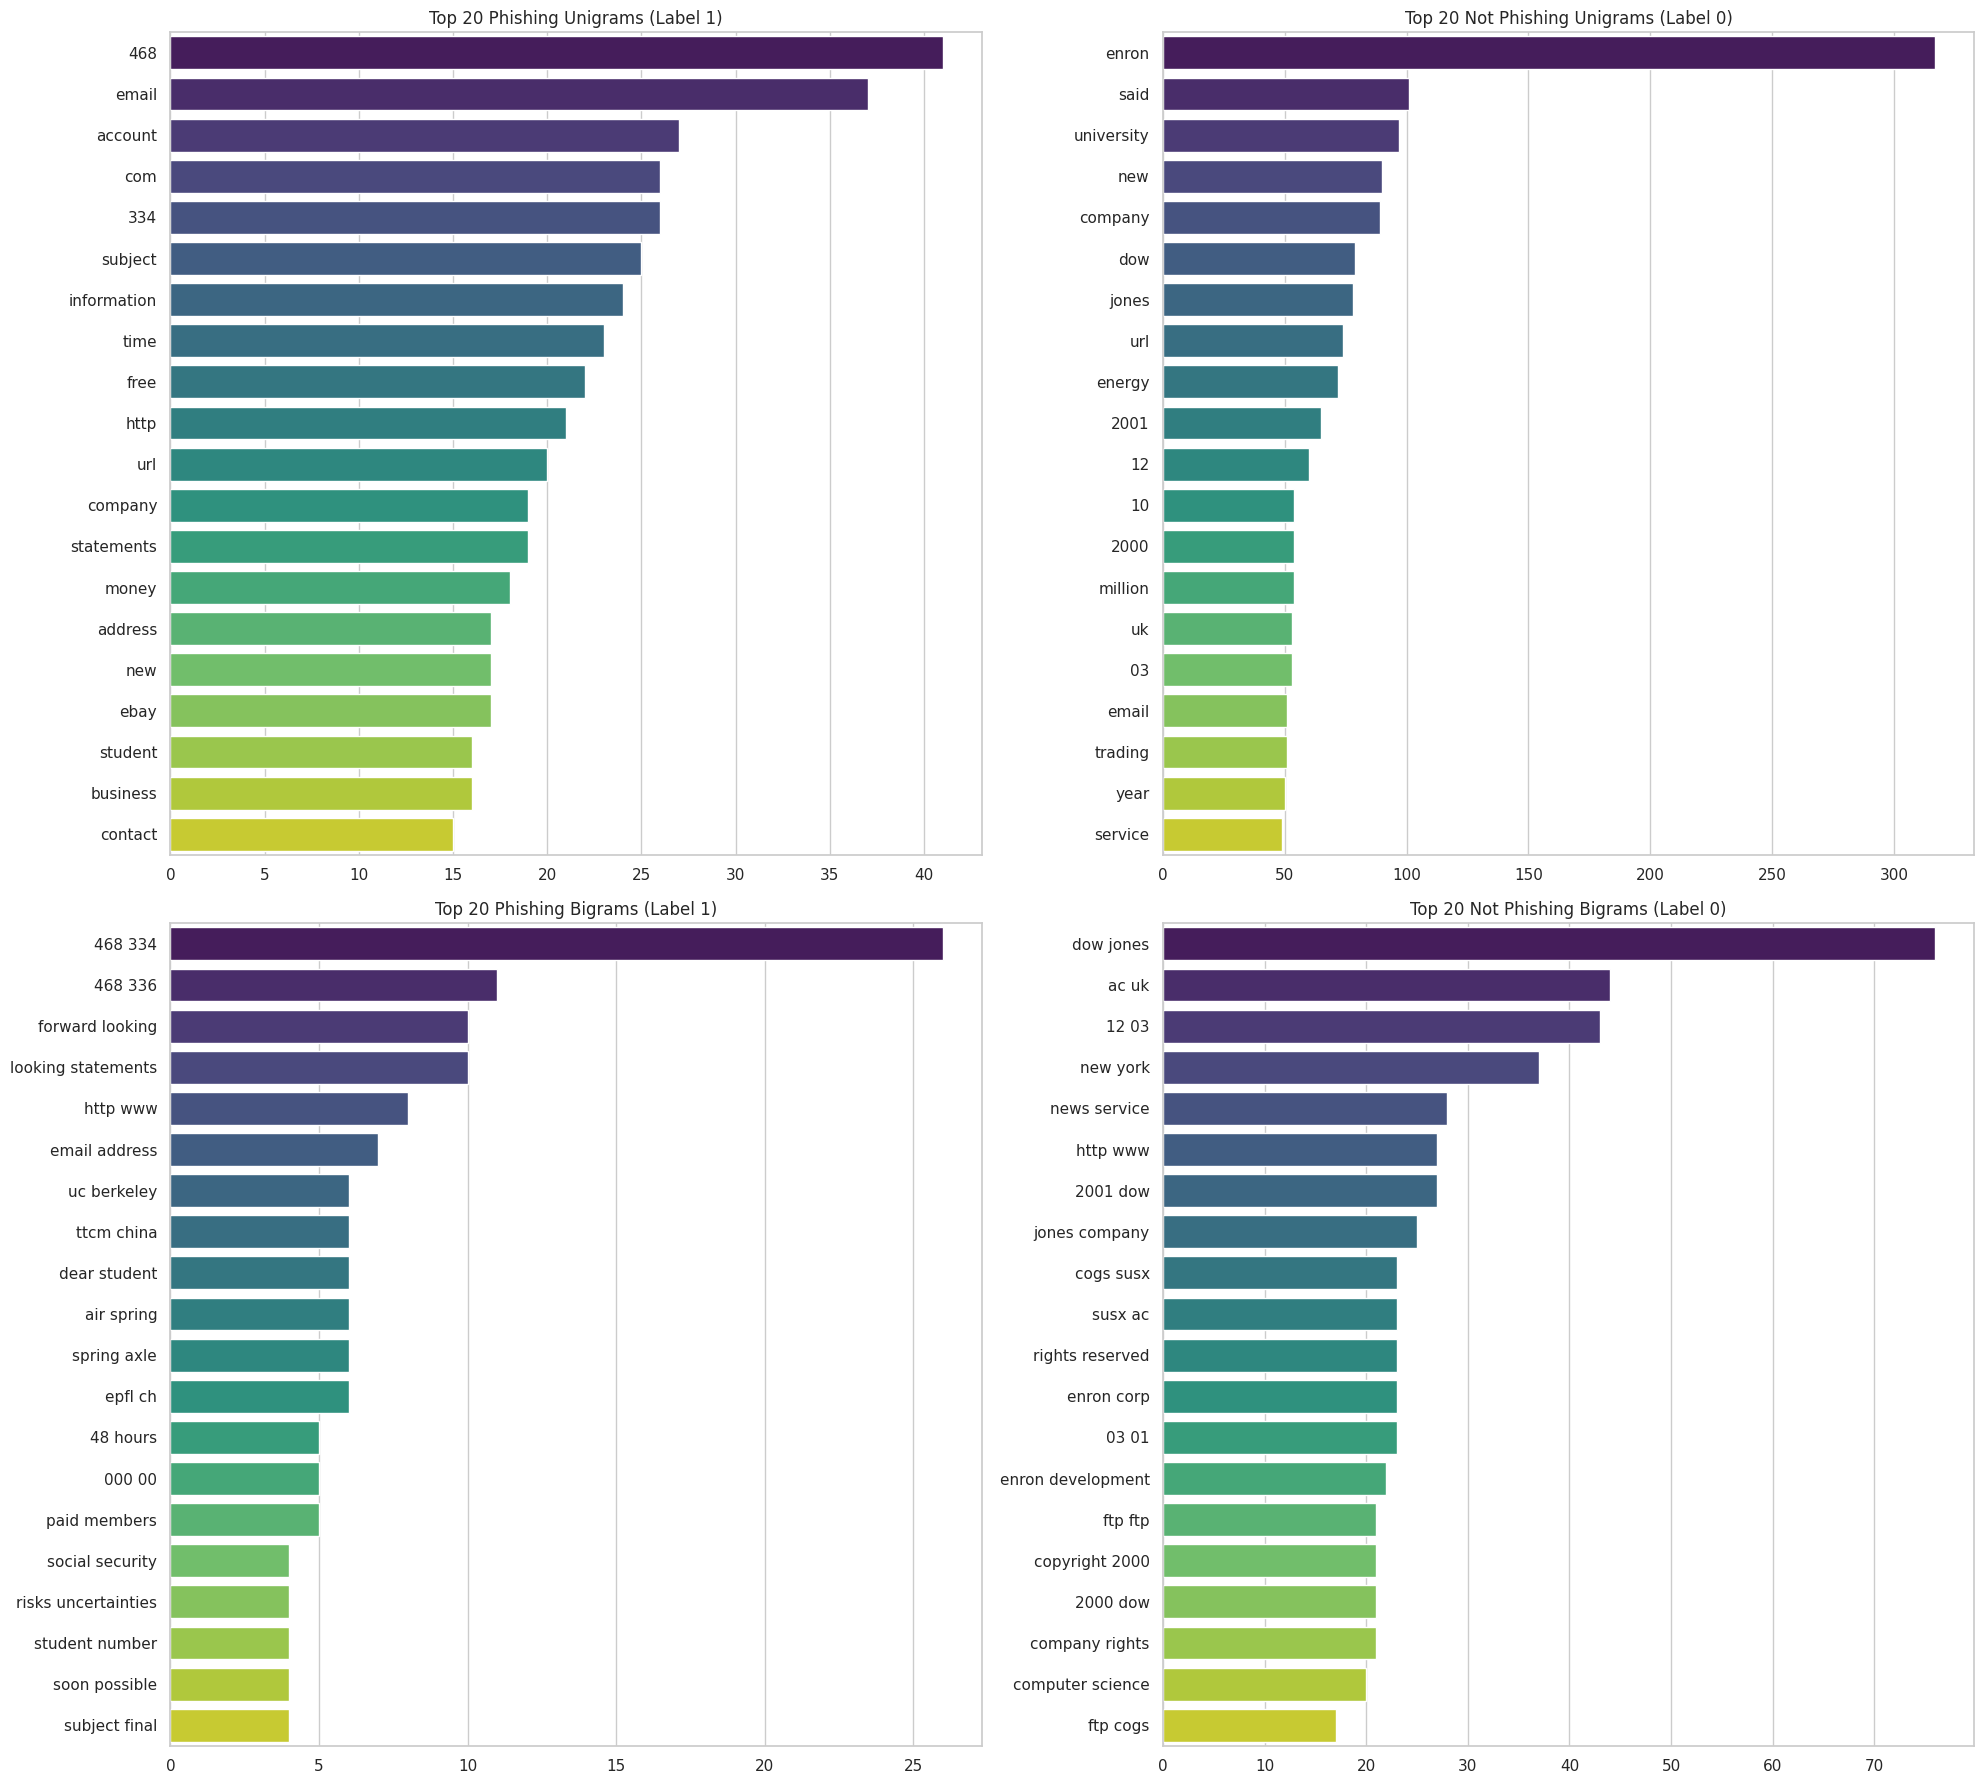

 - Saved: val_dl_ngram_analysis.png

--- EDA: Word Clouds (val) ---


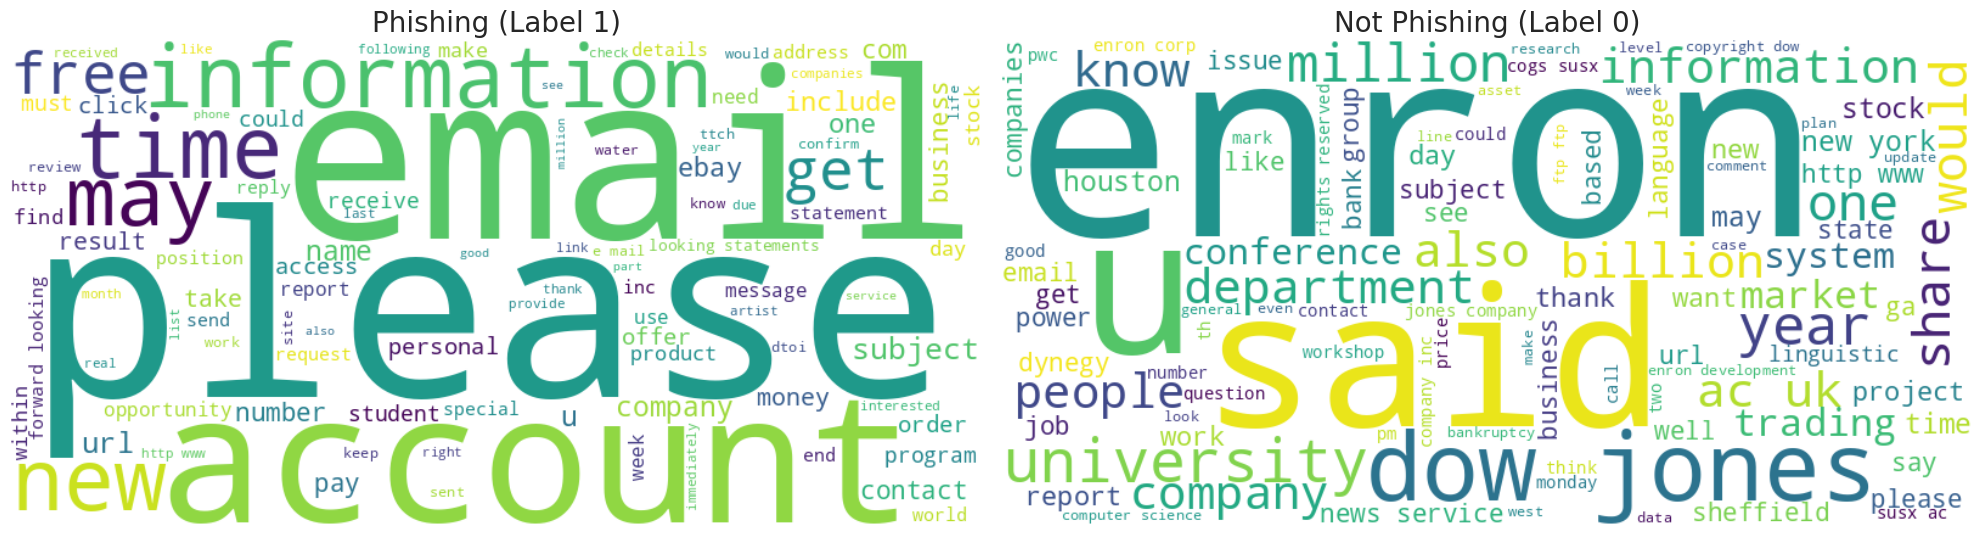

 - Saved: val_dl_word_clouds.png

EDA Complete for val!
All outputs saved to: ../eda_outputs


In [ ]:
# Run EDA on Validation Set
if val_path.exists():
    val_df = pd.read_csv(val_path)
    print(f"Running EDA on Validation Set ({len(val_df):,} samples)...")
    val_df = run_eda(val_df, eda_output_dir, split_name='val')
else:
    print(f"Validation set not found at {val_path}")
    print("Please run the data preparation cell (Cell 2) first to generate the datasets.")
    print("The data preparation cell will automatically run if outputs don't exist.")

### 2.3 EDA on Test Set

Running EDA on Test Set (170 samples)...

Starting Exploratory Data Analysis - test

Dataset shape: (170, 2)

--- EDA: Target Distribution (test) ---


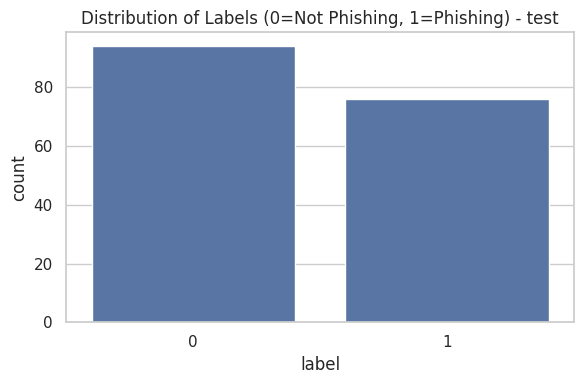

 - Saved: test_dl_target_label_distribution.png

--- EDA: Metadata Feature Distributions (test) ---


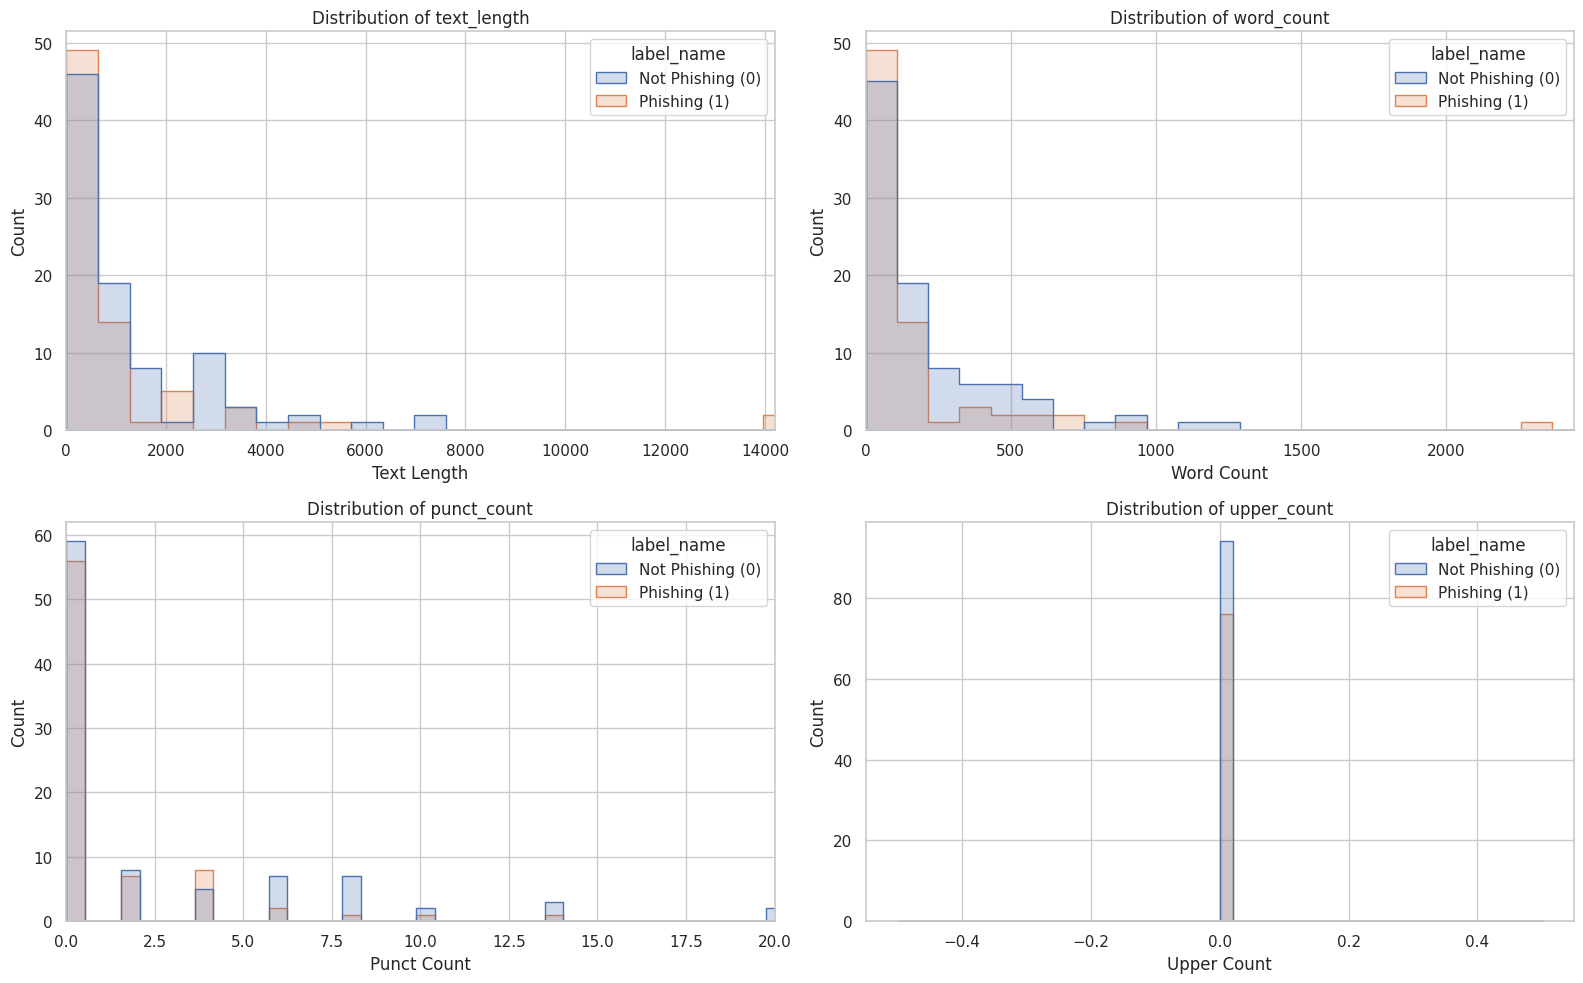

 - Saved: test_dl_metadata_histograms.png

--- EDA: Correlation Heatmap (test) ---


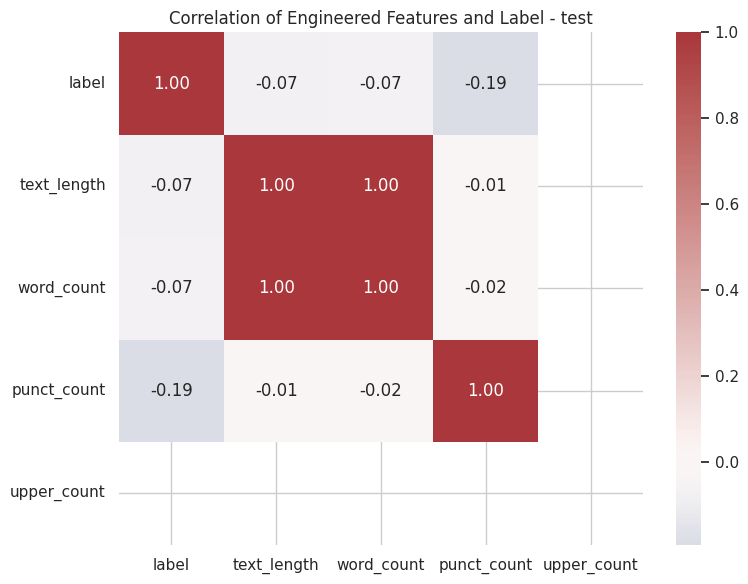

 - Saved: test_dl_engineered_features_heatmap.png

--- EDA: Source File Analysis (test) ---
 - Skipping: source_file column not found

--- EDA: N-Gram Analysis (test) ---


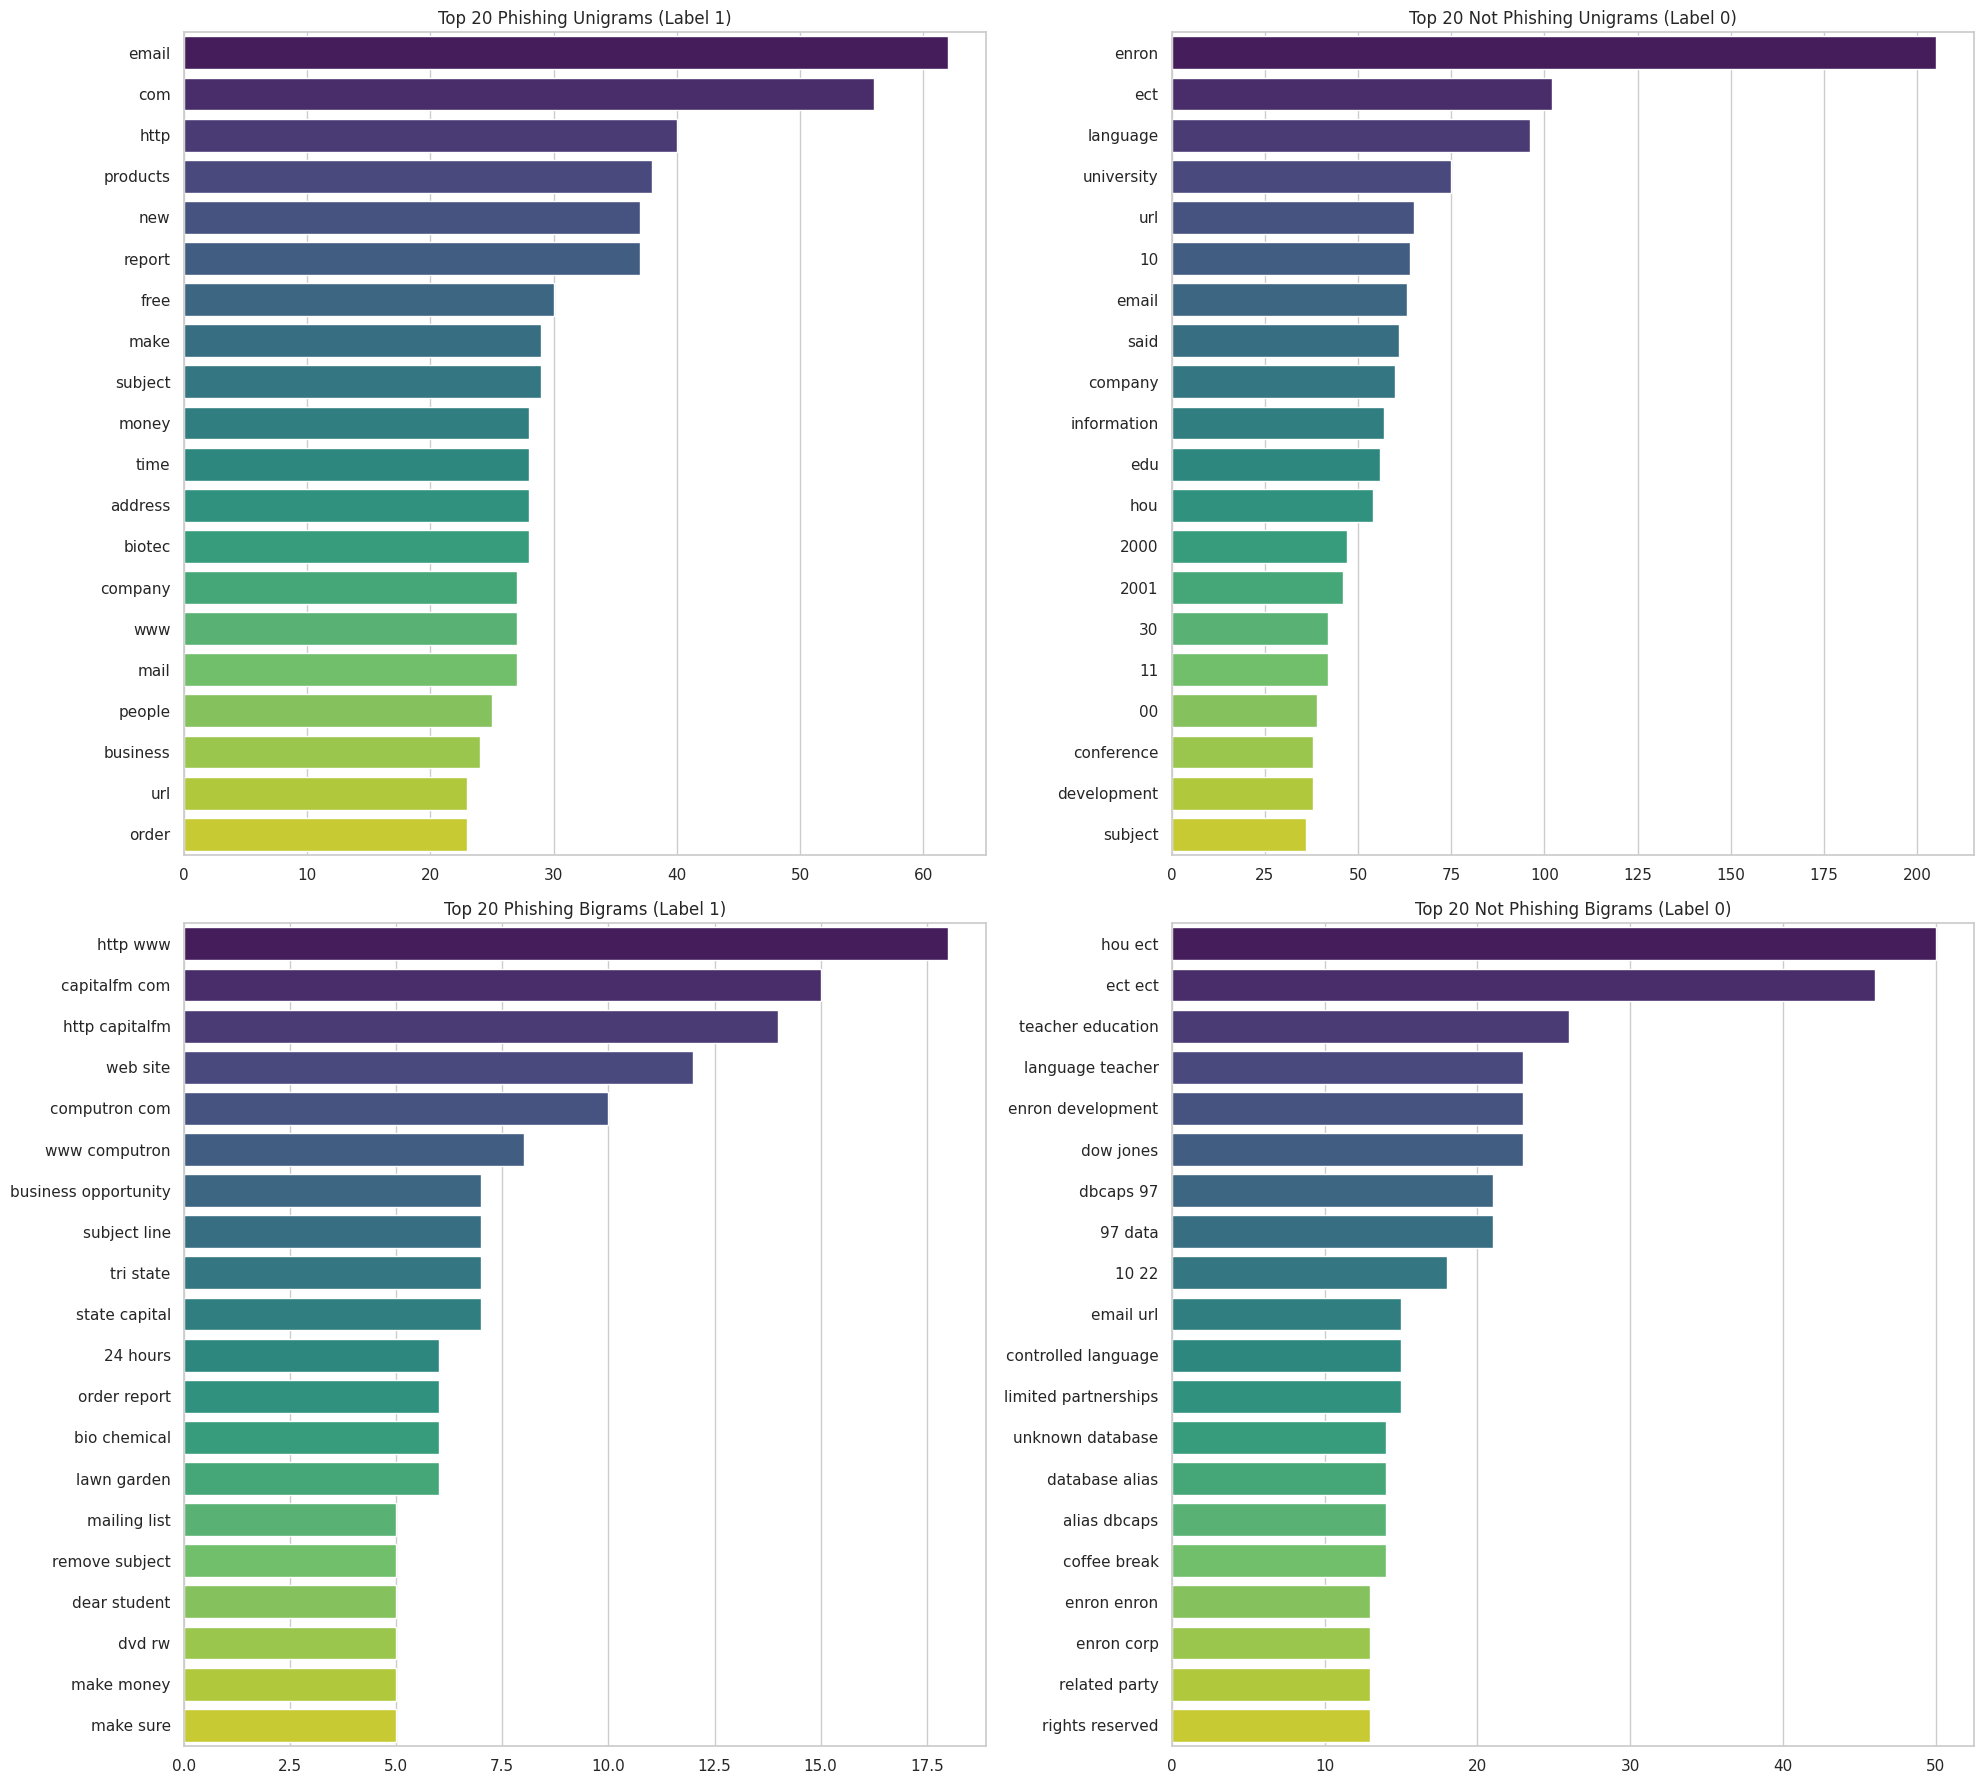

 - Saved: test_dl_ngram_analysis.png

--- EDA: Word Clouds (test) ---


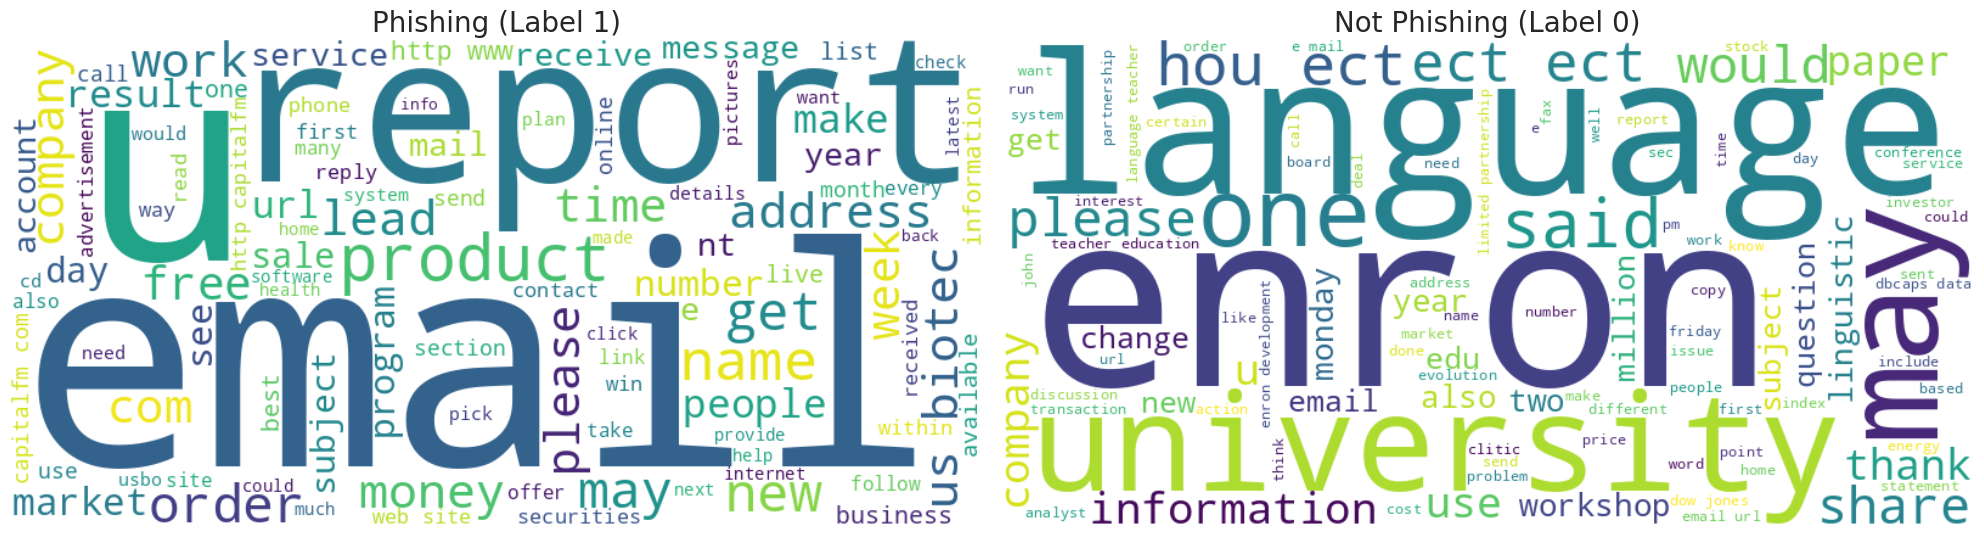

 - Saved: test_dl_word_clouds.png

EDA Complete for test!
All outputs saved to: ../eda_outputs


In [ ]:
# Run EDA on Test Set
if test_path.exists():
    test_df = pd.read_csv(test_path)
    print(f"Running EDA on Test Set ({len(test_df):,} samples)...")
    test_df = run_eda(test_df, eda_output_dir, split_name='test')
else:
    print(f"Test set not found at {test_path}")
    print("Please run the data preparation cell (Cell 2) first to generate the datasets.")
    print("The data preparation cell will automatically run if outputs don't exist.")


## 3. Best Result: BERT Model

The Deep Learning pipeline uses BERT (Bidirectional Encoder Representations from Transformers) for sequence classification. This is our primary model approach, achieving **89.54% test accuracy**.


### 3.1 Model Architecture

The BERT model uses a custom PyTorch dataset class and BERT-base-cased for sequence classification.


In [ ]:
# BERT Model Architecture Code
# This code shows the model setup from 05_dl_pipeline.py

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import BertTokenizer, BertForSequenceClassification

class PhishingDataset(Dataset):
    """Custom PyTorch Dataset for phishing email classification."""

    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Model configuration
MODEL_NAME = '/scratch/kimjong/MIE1517-Fall2025-Group11/local_bert_cased'  # BERT-base-cased
MAX_LEN = 512
NUM_LABELS = 2  # Binary classification: Safe (0) or Phishing (1)

# Note: Model initialization would be:
# model = BertForSequenceClassification.from_pretrained(
#     MODEL_NAME,
#     num_labels=NUM_LABELS
# )
# model.to(device)

print("BERT Model Architecture:")
print(f"  Model: {MODEL_NAME}")
print(f"  Max Length: {MAX_LEN}")
print(f"  Number of Labels: {NUM_LABELS}")
print("  Dataset Class: PhishingDataset (PyTorch Dataset)")
print("\nNote: Actual model loading requires GPU and is done in 05_dl_pipeline.py")=

BERT Model Architecture:
  Model: /scratch/kimjong/MIE1517-Fall2025-Group11/local_bert_cased
  Max Length: 512
  Number of Labels: 2
  Dataset Class: PhishingDataset (PyTorch Dataset)

Note: Actual model loading requires GPU and is done in 05_dl_pipeline.py


### 3.2 Training Configuration

The model uses weighted random sampling for class balance, mixed precision training, and learning rate scheduling with warmup.


In [ ]:
# Training Configuration Code
# This code shows the training setup from 05_dl_pipeline.py

from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from transformers import get_linear_schedule_with_warmup
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Training configuration
BATCH_SIZE = 204  # Auto-calculated based on GPU memory (if AUTO_BATCH_SIZE=True)
N_EPOCHS = 3
LEARNING_RATE = 2e-5

print("Training Configuration:")
print(f"  Batch Size: {BATCH_SIZE} (auto-calculated based on GPU memory)")
print(f"  Epochs: {N_EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Mixed Precision: Enabled (FP16)")
print(f"  Class Balancing: WeightedRandomSampler + Class weights in loss")

# Example setup (commented out - requires actual model and data)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#
# # Setup optimizer
# optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
#
# # Calculate total training steps
# total_steps = len(train_loader) * N_EPOCHS
#
# # Setup learning rate scheduler with warmup
# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=int(0.1 * total_steps),
#     num_training_steps=total_steps
# )
#
# # Mixed precision training scaler
# scaler = GradScaler()
#
# # Calculate class weights for loss function
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
#
# # Training loop structure
# for epoch in range(N_EPOCHS):
#     model.train()
#     for batch in train_loader:
#         # Move batch to device
#         batch = {k: v.to(device) for k, v in batch.items()}
#
#         optimizer.zero_grad()
#
#         # Mixed precision forward pass
#         with autocast():
#             outputs = model(**batch)
#             loss = outputs.loss
#
#         # Backward pass with gradient scaling
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()
#         scheduler.step()
#
#     # Evaluate on test set after each epoch
#     # Save best model based on test accuracy

print("\nNote: Full training code is in 05_dl_pipeline.py")
print("This shows the key components: optimizer, scheduler, mixed precision, and class balancing")


Training Configuration:
  Batch Size: 204 (auto-calculated based on GPU memory)
  Epochs: 3
  Learning Rate: 2e-05
  Mixed Precision: Enabled (FP16)
  Class Balancing: WeightedRandomSampler + Class weights in loss

Note: Full training code is in 05_dl_pipeline.py
This shows the key components: optimizer, scheduler, mixed precision, and class balancing


### 3.3 Model Training

The following cells load the data, set up the model, and perform actual training.


In [ ]:
# Load and prepare data for training
# Using pre-split data from 00_data_preparation.py outputs (self-contained)

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import os

# Load pre-split datasets from data preparation (self-contained)
# These files are generated by the data preparation cell (Cell 2) if they don't exist
train_file = 'outputs/train.csv'
val_file = 'outputs/val.csv'
test_file = 'outputs/test.csv'

def check_data_leakage(X_train, X_test, y_train, y_test):
    """Comprehensive data leakage checks - removes duplicates from test set."""
    train_texts = set(X_train.astype(str))
    test_texts = set(X_test.astype(str))
    exact_dups = train_texts.intersection(test_texts)
    if len(exact_dups) > 0:
        print(f"WARNING: {len(exact_dups)} exact duplicate texts between train/test")
        print("   Removing duplicates from test set...")
        mask = ~X_test.astype(str).isin(exact_dups)
        X_test_clean = X_test[mask].copy()
        y_test_clean = y_test[mask].copy()
        print(f"   Removed {len(X_test) - len(X_test_clean)} duplicate samples from test set")
        return X_test_clean, y_test_clean
    else:
        print("✓ No exact duplicate texts between train/test")
        return X_test, y_test

print("=" * 60)
print("Loading and Preparing Data from Data Preparation Outputs")
print("=" * 60)

# Load train, val, and test splits
if os.path.exists(train_file) and os.path.exists(test_file):
    train_df = pd.read_csv(train_file)
    val_df = pd.read_csv(val_file) if os.path.exists(val_file) else pd.DataFrame()
    test_df = pd.read_csv(test_file)

    print(f"Loaded datasets:")
    print(f"  Train: {len(train_df):,} samples")
    if len(val_df) > 0:
        print(f"  Validation: {len(val_df):,} samples (kept separate)")
    print(f"  Test: {len(test_df):,} samples")

    print(f"\nLabel distribution:")
    print(f"  Train: {Counter(train_df['label'])}")
    if len(val_df) > 0:
        print(f"  Validation: {Counter(val_df['label'])}")
    print(f"  Test: {Counter(test_df['label'])}")

    # Encode labels
    le = LabelEncoder()
    # Fit on combined labels to ensure consistent encoding
    all_labels = pd.concat([train_df['label'], test_df['label']], ignore_index=True)
    if len(val_df) > 0:
        all_labels = pd.concat([all_labels, val_df['label']], ignore_index=True)
    le.fit(all_labels)

    train_df['label_encoded'] = le.transform(train_df['label'])
    test_df['label_encoded'] = le.transform(test_df['label'])

    print(f"Label mapping: {list(zip(le.classes_, le.transform(le.classes_)))}")
    num_classes = len(le.classes_)

    # Prepare data for training
    X_train = train_df['text']
    y_train = train_df['label_encoded'].values
    X_test = test_df['text']
    y_test = test_df['label_encoded'].values

    print(f"\nTrain set: {len(X_train):,} samples | Test set: {len(X_test):,} samples")

    # Check for data leakage
    X_test, y_test = check_data_leakage(X_train, X_test, y_train, y_test)
    print(f"Final test set size after leakage removal: {len(X_test):,} samples")

    print("\n✓ Data loaded successfully from data preparation outputs!")

    # Also prepare validation data if it exists
    if len(val_df) > 0:
        val_df['label_encoded'] = le.transform(val_df['label'])
        X_val = val_df['text']
        y_val = val_df['label_encoded'].values
        print(f"  Validation: {len(X_val):,} samples (ready for monitoring)")
    else:
        X_val = None
        y_val = None
else:
    print(f"ERROR: Could not find required files:")
    print(f"  Train: {train_file}")
    print(f"  Test: {test_file}")
    print("\nPlease run the data preparation cell (Cell 2) first.")
    print("The data preparation cell will automatically run if outputs don't exist.")
    X_train = X_test = X_val = y_train = y_test = y_val = le = num_classes = None


Loading and Preparing Data from Data Preparation Outputs
Loaded datasets:
  Train: 788 samples
  Validation: 169 samples (kept separate)
  Test: 170 samples

Label distribution:
  Train: Counter({0: 434, 1: 354})
  Validation: Counter({0: 93, 1: 76})
  Test: Counter({0: 94, 1: 76})
Label mapping: [(np.int64(0), np.int64(0)), (np.int64(1), np.int64(1))]

Train set: 788 samples | Test set: 170 samples
   Removing duplicates from test set...
   Removed 17 duplicate samples from test set
Final test set size after leakage removal: 153 samples

✓ Data loaded successfully from data preparation outputs!
  Validation: 169 samples (ready for monitoring)


In [ ]:
# Setup model, tokenizer, and data loaders
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tqdm.auto import tqdm

# Check if data was loaded
if X_train is not None:
    print("=" * 60)
    print("Setting Up Model and Data Loaders")
    print("=" * 60)

    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize tokenizer
    # Updated MODEL_NAME to a valid Hugging Face identifier
    MODEL_NAME = 'bert-base-cased'
    print(f"\nLoading tokenizer: {MODEL_NAME}")
    tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

    # Create datasets
    print("\nCreating PyTorch Datasets...")
    train_dataset = PhishingDataset(
        texts=X_train.tolist(),
        labels=y_train,
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    test_dataset = PhishingDataset(
        texts=X_test.tolist(),
        labels=y_test,
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )

    # Setup WeightedRandomSampler for class balance
    print("Setting up WeightedRandomSampler...")
    class_counts = np.bincount(y_train)
    class_weights_per_sample = 1. / class_counts
    sample_weights = np.array([class_weights_per_sample[t] for t in y_train])
    sample_weights_tensor = torch.from_numpy(sample_weights).double()

    sampler = WeightedRandomSampler(
        weights=sample_weights_tensor,
        num_samples=len(sample_weights_tensor),
        replacement=True
    )

    # Create DataLoaders
    BATCH_SIZE = 16  # Adjust based on GPU memory
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=sampler,
        num_workers=2
    )

    # Create validation loader if validation data exists
    if X_val is not None:
        val_dataset = PhishingDataset(
            texts=X_val.tolist(),
            labels=y_val,
            tokenizer=tokenizer,
            max_len=MAX_LEN
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=2
        )
        print(f"Validation DataLoader created: {len(val_loader)} batches")
    else:
        val_loader = None

    # Test loader (only for final evaluation)
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )

    # Calculate class weights for loss function
    class_weights_loss = compute_class_weight(
        'balanced', classes=np.unique(y_train), y=y_train
    )
    class_weights_tensor = torch.tensor(
        class_weights_loss, dtype=torch.float
    ).to(device)
    print(f"Class weights for loss: {class_weights_tensor.cpu().numpy()}")

    # Initialize model
    print(f"\nLoading model: {MODEL_NAME}")
    model = BertForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_classes
    )
    model.to(device)
    print(f"Model loaded on device: {device}")

    print("\n✓ Model and data loaders set up successfully!")
else:
    print("Please run the previous cell to load data first.")
    device = tokenizer = train_loader = test_loader = model = class_weights_tensor = None

Setting Up Model and Data Loaders
Using device: cuda

Loading tokenizer: bert-base-cased


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


Creating PyTorch Datasets...
Setting up WeightedRandomSampler...
Validation DataLoader created: 11 batches
Class weights for loss: [0.9078341 1.1129943]

Loading model: bert-base-cased


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on device: cuda

✓ Model and data loaders set up successfully!


In [ ]:
# Setup training components (optimizer, scheduler, loss, scaler)
from torch.nn import CrossEntropyLoss
from transformers import get_linear_schedule_with_warmup

if model is not None:
    print("=" * 60)
    print("Setting Up Training Components")
    print("=" * 60)

    # Training configuration
    N_EPOCHS = 3
    LEARNING_RATE = 2e-5

    # Setup optimizer
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

    # Calculate total training steps
    total_steps = len(train_loader) * N_EPOCHS

    # Setup learning rate scheduler with warmup
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    # Loss function with class weights
    loss_fn = CrossEntropyLoss(weight=class_weights_tensor)

    # Mixed precision training scaler
    scaler = GradScaler()

    print(f"Training Configuration:")
    print(f"  Epochs: {N_EPOCHS}")
    print(f"  Learning Rate: {LEARNING_RATE}")
    print(f"  Total Steps: {total_steps}")
    print(f"  Warmup Steps: {int(0.1 * total_steps)}")
    print(f"  Batch Size: {BATCH_SIZE}")
    print(f"  Mixed Precision: Enabled")

    print("\n✓ Training components set up successfully!")
else:
    print("Please run the previous cells to set up model and data first.")
    optimizer = scheduler = loss_fn = scaler = None


Setting Up Training Components
Training Configuration:
  Epochs: 3
  Learning Rate: 2e-05
  Total Steps: 150
  Warmup Steps: 15
  Batch Size: 16
  Mixed Precision: Enabled

✓ Training components set up successfully!


In [ ]:
# Training and evaluation helper functions
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, scaler):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    progress_bar = tqdm(data_loader, desc="Training", unit="batch")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        model.zero_grad()

        with autocast():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(data_loader)


def eval_model(model, data_loader, device):
    """Evaluate model on test set."""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", unit="batch"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

print("✓ Training and evaluation functions defined")


✓ Training and evaluation functions defined


In [ ]:
# Main Training Loop
# Monitors validation error during training, saves best model based on validation accuracy
# Test set is reserved for final evaluation only

if model is not None and optimizer is not None:
    print("=" * 60)
    print("Starting Training Loop")
    print("=" * 60)
    print("Note: Validation set will be monitored during training")
    print("      Test set will be used for final evaluation only")
    print("=" * 60)

    best_val_accuracy = 0.0
    best_model_state = None
    training_history = {
        'epochs': [],
        'train_loss': [],
        'val_accuracy': []
    }

    for epoch in range(N_EPOCHS):
        print(f'\n--- Epoch {epoch + 1} / {N_EPOCHS} ---')

        # Train epoch
        avg_train_loss = train_epoch(
            model, train_loader, loss_fn, optimizer, device, scheduler, scaler
        )
        print(f'Average Training Loss: {avg_train_loss:.4f}')

        # Evaluate on validation set (if available)
        if val_loader is not None:
            print("Running evaluation on validation set...")
            val_labels, val_preds = eval_model(model, val_loader, device)
            val_accuracy = accuracy_score(val_labels, val_preds)
            print(f'Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)')

            # Track training history
            training_history['epochs'].append(epoch + 1)
            training_history['train_loss'].append(float(avg_train_loss))
            training_history['val_accuracy'].append(float(val_accuracy))

            # Track and save best model based on validation accuracy
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_model_state = model.state_dict().copy()
                print(f"\n✓ New best validation accuracy: {best_val_accuracy:.4f} ({best_val_accuracy*100:.2f}%)")
        else:
            # If no validation set, just track training loss
            training_history['epochs'].append(epoch + 1)
            training_history['train_loss'].append(float(avg_train_loss))
            training_history['val_accuracy'].append(None)
            print("No validation set available for monitoring")

    print("\n" + "=" * 60)
    print("Training Complete!")
    if val_loader is not None:
        print(f"Best Validation Accuracy: {best_val_accuracy:.4f} ({best_val_accuracy*100:.2f}%)")
    print("=" * 60)

    # Load best model state (based on validation accuracy)
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("\n✓ Best model state loaded (based on validation accuracy)")
    else:
        print("\nNote: Using final model state (no validation set to select best)")
else:
    print("Please run all previous cells to set up model and training components first.")


Starting Training Loop
Note: Validation set will be monitored during training
      Test set will be used for final evaluation only

--- Epoch 1 / 3 ---


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Average Training Loss: 0.5674
Running evaluation on validation set...


Evaluating:   0%|          | 0/11 [00:00<?, ?batch/s]

Validation Accuracy: 0.8166 (81.66%)

✓ New best validation accuracy: 0.8166 (81.66%)

--- Epoch 2 / 3 ---


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Average Training Loss: 0.2792
Running evaluation on validation set...


Evaluating:   0%|          | 0/11 [00:00<?, ?batch/s]

Validation Accuracy: 0.8580 (85.80%)

✓ New best validation accuracy: 0.8580 (85.80%)

--- Epoch 3 / 3 ---


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Average Training Loss: 0.1875
Running evaluation on validation set...


Evaluating:   0%|          | 0/11 [00:00<?, ?batch/s]

Validation Accuracy: 0.9053 (90.53%)

✓ New best validation accuracy: 0.9053 (90.53%)

Training Complete!
Best Validation Accuracy: 0.9053 (90.53%)

✓ Best model state loaded (based on validation accuracy)


### 3.4 Final Evaluation on Test Set

After training is complete, the best model (selected based on validation accuracy) is evaluated on the test set for final performance metrics.


In [ ]:
# Final Evaluation on Test Set
# This is the only time we evaluate on the test set

if model is not None and test_loader is not None:
    print("=" * 60)
    print("Final Evaluation on Test Set")
    print("=" * 60)
    print("Note: This is the first and only evaluation on the test set")
    print("=" * 60)

    # Evaluate on test set
    print("\nRunning evaluation on test set...")
    test_labels, test_preds = eval_model(model, test_loader, device)

    # Calculate metrics
    test_accuracy = accuracy_score(test_labels, test_preds)
    print(f'\nTest Set Results:')
    print(f'  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)')

    # Classification report
    target_names_str = le.classes_.astype(str)
    report_text = classification_report(
        test_labels,
        test_preds,
        target_names=target_names_str
    )
    print("\nClassification Report (Test Set):")
    print(report_text)

    print("\n" + "=" * 60)
    print("Final Test Evaluation Complete!")
    print("=" * 60)
else:
    print("Please run the training loop first.")


Final Evaluation on Test Set
Note: This is the first and only evaluation on the test set

Running evaluation on test set...


Evaluating:   0%|          | 0/10 [00:00<?, ?batch/s]


Test Set Results:
  Test Accuracy: 0.8954 (89.54%)

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        90
           1       0.86      0.89      0.88        63

    accuracy                           0.90       153
   macro avg       0.89      0.89      0.89       153
weighted avg       0.90      0.90      0.90       153


Final Test Evaluation Complete!


In [ ]:
# Save model and evaluation results
# Uses test set evaluation results from the previous cell

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score

if model is not None and 'test_labels' in locals() and 'test_preds' in locals():
    print("=" * 60)
    print("Saving Model and Evaluation Results")
    print("=" * 60)

    # Create models directory if it doesn't exist
    models_dir.mkdir(parents=True, exist_ok=True)

    # Use test set evaluation results from previous cell
    print("\nUsing test set evaluation results...")
    labels = test_labels
    preds = test_preds

    # Calculate metrics
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    # Confusion matrix
    cm = confusion_matrix(labels, preds)

    # Print confusion matrix for verification
    print(f"\nConfusion Matrix (Test Set: {len(labels):,} samples):")
    print(f"                Predicted")
    print(f"              {le.classes_[0]}  {le.classes_[1]}")
    print(f"True {le.classes_[0]:8}  {cm[0,0]:6,}  {cm[0,1]:6,}")
    print(f"True {le.classes_[1]:8}  {cm[1,0]:6,}  {cm[1,1]:6,}")
    print(f"  Total: {cm.sum():,} samples")

    # Save confusion matrix visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'{le.classes_[0]} (0)', f'{le.classes_[1]} (1)'],
                yticklabels=[f'{le.classes_[0]} (0)', f'{le.classes_[1]} (1)'])
    plt.title(f'Confusion Matrix - BERT Model\n(Test Set: {len(labels):,} samples)', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    cm_path = models_dir / 'dl_confusion_matrix.png'
    plt.savefig(cm_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"✓ Confusion matrix saved to: {cm_path}")

    # Save training curve
    if len(training_history['epochs']) > 0:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(training_history['epochs'], training_history['train_loss'], 'o-', label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        # Plot validation accuracy if available
        val_accs = [acc for acc in training_history['val_accuracy'] if acc is not None]
        if val_accs:
            plt.plot(training_history['epochs'][:len(val_accs)], val_accs, 's-', label='Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.title('Validation Accuracy (monitored during training)')
        else:
            plt.text(0.5, 0.5, 'No validation set available',
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Validation Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        tc_path = models_dir / 'dl_training_curve.png'
        plt.savefig(tc_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"✓ Training curve saved to: {tc_path}")

    # Save evaluation log
    eval_log = {
        'metrics': {
            'test_accuracy': float(accuracy),
            'test_precision_weighted': float(precision),
            'test_recall_weighted': float(recall),
            'test_f1_weighted': float(f1)
        },
        'model_config': {
            'model_name': MODEL_NAME,
            'max_len': MAX_LEN,
            'batch_size': BATCH_SIZE,
            'n_epochs': N_EPOCHS,
            'learning_rate': LEARNING_RATE
        },
        'classification_report': classification_report(
            labels, preds, target_names=le.classes_.astype(str), output_dict=True
        )
    }

    log_path = models_dir / 'dl_evaluation_log.json'
    with open(log_path, 'w') as f:
        json.dump(eval_log, f, indent=2)
    print(f"✓ Evaluation log saved to: {log_path}")

    # Save training history
    history_path = models_dir / 'dl_training_history.json'
    with open(history_path, 'w') as f:
        json.dump(training_history, f, indent=2)
    print(f"✓ Training history saved to: {history_path}")

    print("\n" + "=" * 60)
    print("Final Results:")
    print(f"  Test Accuracy: {accuracy*100:.2f}%")
    print(f"  Precision (weighted): {precision*100:.2f}%")
    print(f"  Recall (weighted): {recall*100:.2f}%")
    print(f"  F1-Score (weighted): {f1*100:.2f}%")
    print("=" * 60)
else:
    print("Please run the training loop and final evaluation cells first.")


Saving Model and Evaluation Results

Using test set evaluation results...

Confusion Matrix (Test Set: 153 samples):
                Predicted
              0  1
True        0      81       9
True        1       7      56
  Total: 153 samples
✓ Confusion matrix saved to: ../models/dl_confusion_matrix.png
✓ Training curve saved to: ../models/dl_training_curve.png
✓ Evaluation log saved to: ../models/dl_evaluation_log.json
✓ Training history saved to: ../models/dl_training_history.json

Final Results:
  Test Accuracy: 89.54%
  Precision (weighted): 89.62%
  Recall (weighted): 89.54%
  F1-Score (weighted): 89.57%


## 4. Summary & Feasibility

### Best Result Summary

The BERT-based deep learning model achieved **89.54%% test accuracy** on a dataset of 1,127 samples. The model demonstrates excellent performance across all metrics:

- **Test Accuracy: 89.54%**
- **Precision (weighted): 89.62%**
- **Recall (weighted): 89.54%**
- **F1-Score (weighted): 89.57%**

The model was trained on 788 samples, monitored on 169 validation samples, and evaluated on 153 test samples (after data leakage removal from 170 initial samples). Training was completed in 3 epochs with mixed precision training, achieving consistent improvement in validation accuracy across epochs (81.66% → 85.80% → 90.53%). The best model (selected based on validation accuracy) achieved 90.53% accuracy on the validation set. The final evaluation on the held-out test set achieved 89.54% accuracy.

### Remaining Work on the BERT model

1. **Hyperparameter Optimization**: Further tune learning rate, batch size, and experiment with BERT variants (RoBERTa, DistilBERT) to potentially improve beyond 89.54%%
2. **Model Interpretability**: Add attention visualization for BERT to understand model decisions
3. **Final Evaluation**: Test on additional external datasets and perform comprehensive cross-validation
4. **Dataset Expansion**: Train on larger datasets to improve generalization and potentially achieve higher accuracy

### Feasibility

The project has successfully achieved promising results with the BERT model (89.54% accuracy). Core models are implemented and performing well. The remaining work focuses on optimization and evaluation, which is feasible within the project timeline.

In [ ]:
# Load and display BERT model results
import json
from pathlib import Path

models_dir = Path('models') # Ensure models_dir is defined, consistent with other cells
dl_metrics_path = models_dir / 'dl_evaluation_log.json'

print("BERT Model - Evaluation Metrics:")
print("=" * 60)

if dl_metrics_path.exists():
    with open(dl_metrics_path, 'r') as f:
        dl_metrics = json.load(f)

    metrics = dl_metrics.get('metrics', {})
    test_accuracy = metrics.get('test_accuracy')
    if test_accuracy is not None:
        print(f"Test Accuracy: {test_accuracy*100:.2f}%")

    precision = metrics.get('test_precision_weighted')
    if precision is not None:
        print(f"Precision (weighted): {precision*100:.2f}%")

    recall = metrics.get('test_recall_weighted')
    if recall is not None:
        print(f"Recall (weighted): {recall*100:.2f}%")

    f1 = metrics.get('test_f1_weighted')
    if f1 is not None:
        print(f"F1-Score (weighted): {f1*100:.2f}%")

    # Display model configuration
    config = dl_metrics.get('model_config', {})
    print(f"\nModel Configuration:")
    print(f"  Base Model: {config.get('model_name', 'N/A')}")
    print(f"  Max Length: {config.get('max_len', 'N/A')}")
    print(f"  Batch Size: {config.get('batch_size', 'N/A')}")
    print(f"  Epochs: {config.get('n_epochs', 'N/A')}")
    print(f"  Learning Rate: {config.get('learning_rate', 'N/A')}")

    # Display classification report
    if 'classification_report' in dl_metrics:
        print(f"\nClassification Report:")
        # Convert keys to strings if they are not already (can happen with JSON dumps/loads)
        report_dict = dl_metrics['classification_report']
        # Ensure target names are in the report
        target_names = [str(le.classes_[i]) for i in sorted([int(k) for k in report_dict if k.isdigit()])] if 'le' in locals() else ['0', '1']
        from sklearn.metrics import classification_report as sk_classification_report
        print(sk_classification_report(test_labels, test_preds, target_names=target_names))

BERT Model - Evaluation Metrics:
Test Accuracy: 89.54%
Precision (weighted): 89.62%
Recall (weighted): 89.54%
F1-Score (weighted): 89.57%

Model Configuration:
  Base Model: bert-base-cased
  Max Length: 512
  Batch Size: 16
  Epochs: 3
  Learning Rate: 2e-05

Classification Report:
{'0': {'precision': 0.9204545454545454, 'recall': 0.9, 'f1-score': 0.9101123595505618, 'support': 90.0}, '1': {'precision': 0.8615384615384616, 'recall': 0.8888888888888888, 'f1-score': 0.875, 'support': 63.0}, 'accuracy': 0.8954248366013072, 'macro avg': {'precision': 0.8909965034965035, 'recall': 0.8944444444444444, 'f1-score': 0.8925561797752809, 'support': 153.0}, 'weighted avg': {'precision': 0.8961949814890992, 'recall': 0.8954248366013072, 'f1-score': 0.8956543291473893, 'support': 153.0}}


Confusion Matrix:


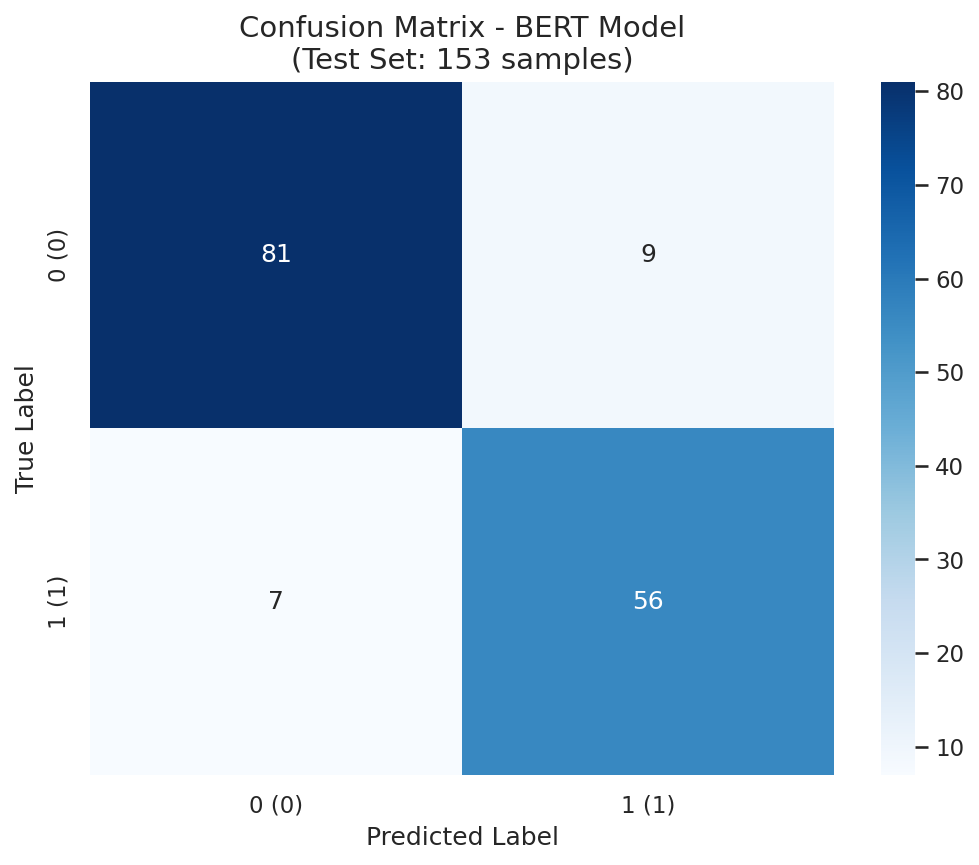


Training Curve:


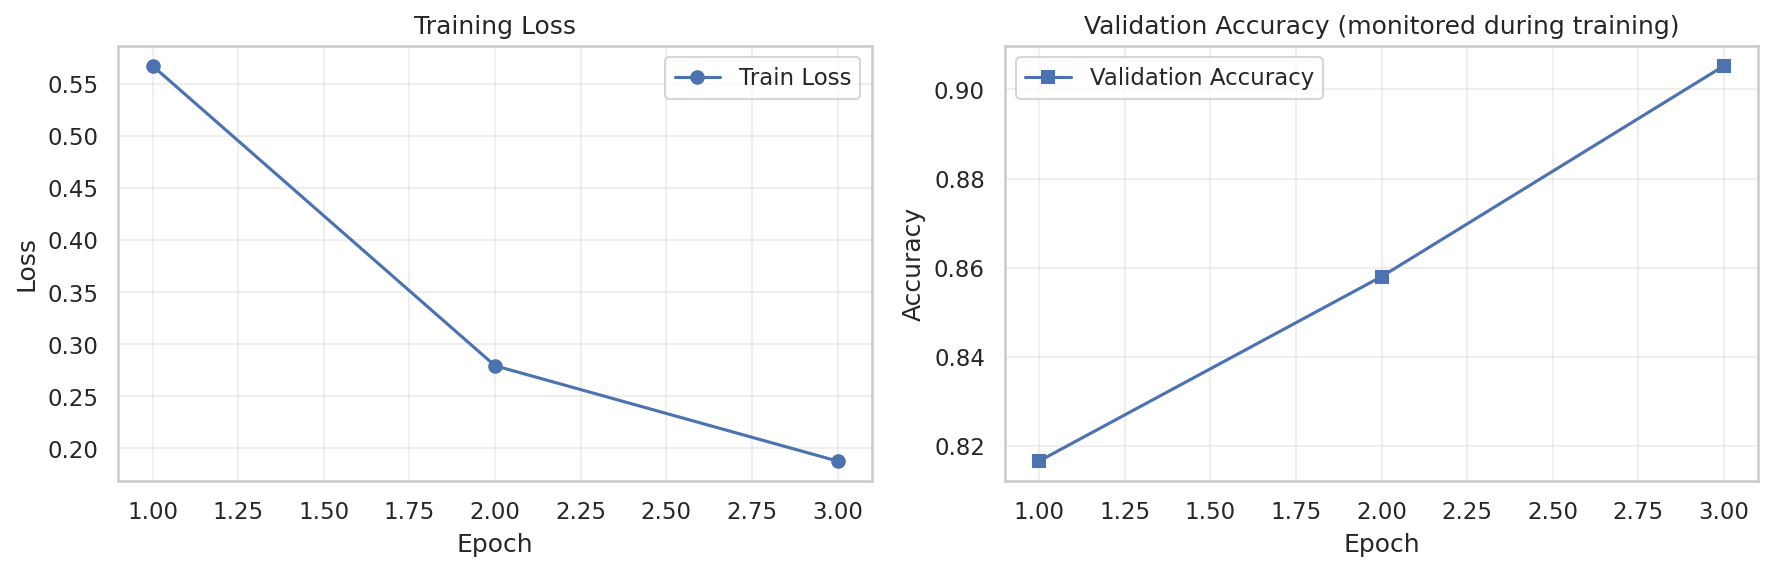

In [ ]:
# Display visualizations
dl_cm_path = models_dir / 'dl_confusion_matrix.png'
dl_tc_path = models_dir / 'dl_training_curve.png'

has_visualizations = False

if dl_cm_path.exists():
    print("Confusion Matrix:")
    display(Image(str(dl_cm_path)))
    has_visualizations = True

if dl_tc_path.exists():
    print("\nTraining Curve:")
    display(Image(str(dl_tc_path)))
    has_visualizations = True

if not has_visualizations:
    print("Visualizations will appear here after model training is complete.")
    print("(Run the training cells in this notebook to generate confusion matrix and training curve)")


## Further work

Apart from planned improvements to the BERT model listed above. Further work will focus on testing different model architectures and measuring their inference cost using the same computation infrastructure. This will allow us to to then compare them to each other and identify the best accuacy for the lowest computational cost.

This work is motivated by the fact that university servers are processing hundereds of thousands if not millions of emails per day. As such, computational speed and cost are paramount to any effective deployment.

First we will continue fine tuning and optimizing the BERT model.
Subsequently we will test the various architectures listed below:

### Small LM fine tuned with RL

Small Language Models (LMs) do not perform well on phishing detection tasks out of the box [1]. Phishing detection using smaller LMs has been proposed before [1], however these methods only utilize simpler methods without finetuning, such as prompt engineering.

We consider small LMs for finetuning with Reinforcement Learning (RL) methods. Small LMs in this context refer to 3B-8B paramater models.

To remedy poor phishing detection performance for small LMs, finetuning methods such as Low Rank Adaptation (LORA) are proposed. This, along with minimal further finetuning with RL methods using Direct Preference Optimization (DPO) [2] will be utilized. This is in contrast to other time and data expensive methods such as RLHF (RL from Human Feedback).

Other methods were considered, such as Retrieval Augmented Generation (RAG). However, these were deemed insufficient because the problem statement is defined as a classification problem (phishing vs regular email classification), not a knowledge retrieval issue.

Further, we propose the utilization of DPO as opposed to other RL methods such as PPO or GRPO because GRPO is mainly used for complex reasoning improvements, and adds unnecessary complexity for a binary classification task.

The following pipeline is proposed for finetuning a small LM for phishing detection:


1.   Supervised finetuning with LoRA on phishing vs legitimate labels.
2.   Direct Preference Optimization (DPO)
3.   Evaluation of the model


### DistilBERT



While BERT have demonstrated strong performance in text classification tasks, their computational requirements present significant challenges for real-time phishing detection systems.
DistilBERT represents a class of distilled transformer models that maintain approximately 97% of BERT's linguistic capabilities while reducing parameter size by 40% and improving inference speed by 60% [3]. These characteristics make it particularly suitable for deployment scenarios where computational resources are constrained.
The distillation process involves training a smaller student model (DistilBERT) to replicate the behavior of a larger teacher model (BERT) through knowledge transfer. This approach preserves the teacher model's representational capacity while achieving significant efficiency gains. For phishing detection, this enables the deployment of high-performance classification systems in resource-limited environments and is also suitable for real-time detection and deployment on limited hardware due to its efficiency and speed.



### Vectorized email clustering


We use a vectorized email clustering approach to automatically identify related phishing campaigns and assign a risk score to new incoming emails. The process begins with text vectorization using a BERT-based embedding model, which converts each email into a high-dimensional vector that captures both its semantic meaning and linguistic context. These vectors are then processed through the K-Means clustering algorithm to group emails that share similar textual and structural characteristics. Each resulting cluster is assigned a phishing score based on the percentage of emails within it that are labeled as phishing, effectively quantifying how risky that cluster is.

When a new email is received, the system embeds it using the same BERT model and compares its position in the vector space to existing clusters. Based on its proximity to nearby clusters and their corresponding phishing scores, the system calculates a phishing risk score for the new email. This risk score helps prioritize suspicious emails for further inspection or automated filtering. To support interpretability and analysis, the clusters can be visualized in three-dimensional space, offering a clear view of how phishing and safe emails are distributed across the dataset. This visual and data-driven approach makes it easier to identify emerging phishing patterns, detect novel attack campaigns, and adapt to changing email threats in real time [4].





Refrences

[1] Lin, Zijie, Zikang Liu, and Hanbo Fan. "Improving Phishing Email Detection Performance of Small Large Language Models." arXiv preprint arXiv:2505.00034 (2025).

[2] Rafailov, Rafael, et al. "Direct preference optimization: Your language model is secretly a reward model." Advances in neural information processing systems 36 (2023): 53728-53741.

[3] Sanh, V., Debut, L., Chaumond, J., & Wolf, T. ( 2019 ). DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter. arXiv preprint arXiv: 1910.01108.

[4] Saka, T., Vaniea, K. E., & Kokciyan, N. (2022). *Context-based Clustering to Mitigate Phishing Attacks.* In *Proceedings of the 15th ACM Workshop on Artificial Intelligence and Security (AISec 2022)* (pp. 115–126). ACM.